In [2]:
#importing the libraries required for the evaluation
import numpy as np
import rasterio
from pygeotools.lib import malib, warplib, iolib,geolib, timelib
import numpy.ma as ma
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from imview.lib import pltlib
from osgeo import gdal, ogr

### Reading RED and SWIR Bands of Landsat ETM+

In [3]:
fn1='LE71480371999229AGS00_B3.TIF'
fn2='LE71480371999229AGS00_B5.TIF'
fn_list=[fn1,fn2]
ds_list = warplib.memwarp_multi_fn(fn_list, extent='intersection', res='max', t_srs=fn1)


Warping all inputs to the following:
Resolution: 30.0
Extent: [471585.0, 3566085.0, 706515.0, 3777615.0]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: LE71480371999229AGS00_B3.TIF
2 of 2: LE71480371999229AGS00_B5.TIF


### Defining Function for Ploting Rasters using Inferno Maps

In [4]:
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(adjustable='box-forced', aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

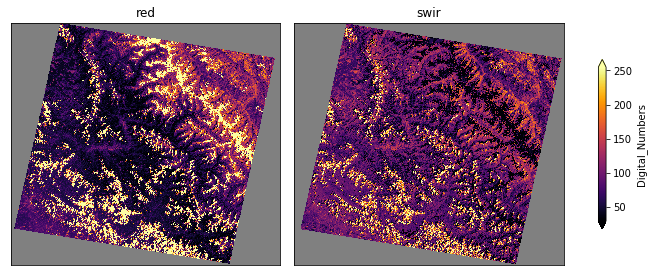

In [5]:
red, swir = [iolib.ds_getma(i) for i in ds_list]
band_list = [red, swir]
titles = ['red', 'swir']
clim = malib.calcperc(band_list[0], (2,98))
plot3panel(band_list, clim, titles, 'inferno', 'Digital_Numbers', fn='dem.png')

In [6]:
band_ratio=red/swir

In [7]:
malib.print_stats(band_ratio)

count: 38002156 min: 0.00 max: 82.00 mean: 0.97 std: 2.33 med: 0.00 mad: 0.00 q1: 0.00 q2: 1.00 iqr: 1.00 mode: 0.00 p16: 0.00 p84: 1.00 spread: 0.50


(38002156,
 0,
 82,
 0.97248556108237649,
 2.329824929796287,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.5)

### Limiting Band Ratio of Red/SWIR to 2.2 (Kaab et al. 2012) 

In [8]:
debris=ma.masked_outside(band_ratio,0, 2.2)

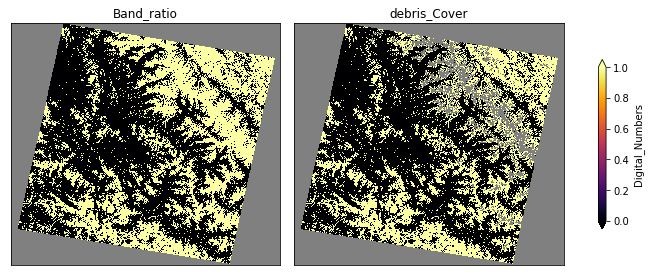

In [9]:
band_list = [band_ratio, debris]
titles = ['Band_ratio', 'debris_Cover']
clim = malib.calcperc(band_list[1], (2,98))
plot3panel(band_list, clim, titles, 'inferno', 'Digital_Numbers', fn='dem.png')

### Eliminating scattered Pixels as Noise using the mask_island function (malib, pygeotools)
## Be careful on the number of itereations, higher iterations might filter out valid continous data near edges as well

In [65]:
Debris_Islands_masked=malib.mask_islands(debris,iterations=2)

In [66]:
out_fn = 'Islands_2.tif' 
iolib.writeGTiff(Debris_Islands_masked, out_fn, ds_list[1]) #Debris Cover Map with isolated pixels removed

### Reading shapefiles as updatable Features, Entering the percentage Debris covered per feature into a newly created field "DIRTY"

In [67]:
source = ogr.Open('Drung_drung.shp', update=True)
layer = source.GetLayer()
layer_defn = layer.GetLayerDefn()
new_field = ogr.FieldDefn("Dirty", ogr.OFTReal)
layer.CreateField(new_field)
source = None

In [68]:
glac_shp_fn='Drung_drung.shp'
glac_shp_ds = ogr.Open(glac_shp_fn, update=True) #shapefile_dataset
glac_shp_lyr = glac_shp_ds.GetLayer() #layer of shapefile, all the operations are performed on it....
glac_shp_srs = glac_shp_lyr.GetSpatialRef() #Spatial_reference_of_shapefile
feat_count = glac_shp_lyr.GetFeatureCount() #Feature_Count
print("Input glacier polygon count: %i" % feat_count)


Input glacier polygon count: 27988


In [69]:
print str(glac_shp_srs)

PROJCS["WGS_1984_UTM_Zone_43N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137,298.257223563]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",75],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["Meter",1],
    AUTHORITY["EPSG","32643"]]


In [70]:
#dh_dt='WV_Carto_RateMaps-tile-0-last.tif' #input elevation_difference_map
#dh_dt='Filtered_dh_1_5_IQR.tif' #input elevation_difference_map
#z='B-tile-0.tif' #input DEM
#dh_dt_ds=gdal.Open(dh_dt) 
#z_ds=gdal.Open(z)
Landsat_geom = geolib.ds_geom_intersection(ds_list, t_srs=glac_shp_srs) #intersecting_extent
glac_shp_lyr.SetSpatialFilter(Landsat_geom) #spatial filtering of shapefiles within extent
feat_count = glac_shp_lyr.GetFeatureCount() #now only the polygons within the extents are considered
print("Filtered glacier polygon count: %i" % feat_count)
glac_shp_lyr.ResetReading()

Filtered glacier polygon count: 3036


In [63]:
debris_fieldname = "Percentage_Final"
glacnum_fieldname = "RGIId"

In [71]:
for n, feat in enumerate(glac_shp_lyr):
    print'Hi' #Check to see program flow...
    #Extracting glacier id/name from input shapefiles
    glacnum = feat.GetField(glacnum_fieldname)
    glacnum = float(glacnum.split('-')[-1])
    glacnum_fmt = '%0.5f'
    feat_fn = str(glacnum)
    print("\n%i of %i: %s\n" % (n+1, feat_count, feat_fn))
    glac_geom = feat.GetGeometryRef()
    glac_geom.AssignSpatialReference(glac_shp_srs)
    glac_geom_extent = geolib.geom_extent(glac_geom)
    glac_area = glac_geom.GetArea()
    print str(glac_area)
    #warping the Landsat_Band and Debris_islanded into common extents
    ds_list1 = warplib.memwarp_multi_fn([fn1, out_fn], res='max',r='bilinear',
            extent=glac_geom_extent, t_srs='EPSG:32643', verbose=False)
    glac_geom_mask = geolib.geom2mask(glac_geom, ds_list1[0])
    total_pixel = ma.array(iolib.ds_getma(ds_list1[0]), mask=glac_geom_mask)
    debris_pixel = ma.array(iolib.ds_getma(ds_list1[1]), mask=glac_geom_mask) 
    ds_res = geolib.get_res(ds_list[0])
    valid_Total_area = total_pixel.count()*ds_res[0]*ds_res[1]
    valid_Debris_area = debris_pixel.count()*ds_res[0]*ds_res[1]
    Debris_area_perc = (valid_Debris_area/valid_Total_area)*100
    print("Total_Area ="+str(valid_Total_area))
    print("Total_Debris_Area="+str(valid_Debris_area))
    print("Debris_Area_Percentage="+str(Debris_area_perc))
    glac_shp_lyr.SetFeature(feat)
    feat.SetField("Dirty", Debris_area_perc)
    glac_shp_lyr.SetFeature(feat)
    #feat.SetField(debris_fieldname, Debris_area_perc)
    #layer.SetFeature(feat)
glac_shp_ds=None

Hi

1 of 3036: 14.1301

168333.104884

Warping all inputs to the following:
Resolution: 30.0
Extent: [691529.9500321876, 3643508.249871153, 692440.1184931222, 3643862.7922288757]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 30 res: 30.000
Total_Area =191700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

2 of 3036: 14.13011

194819.574487

Warping all inputs to the following:
Resolution: 30.0
Extent: [691080.078614614, 3644326.7232036507, 691630.4918816497, 3645005.794552535]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 18 res: 30.000
Total_Area =213300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

3 of 3036: 14.13062

5291806.80113

Warping all inputs to the following:
Resolution: 30.0
Exte

2 of 2: Islands_2.tif
nl: 39 ns: 64 res: 30.000
Total_Area =1171800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

26 of 3036: 14.131

1898518.25871

Warping all inputs to the following:
Resolution: 30.0
Extent: [694571.3559196765, 3618995.3835032345, 697025.225804457, 3620938.2086142963]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 65 ns: 82 res: 30.000
2 of 2: Islands_2.tif
nl: 65 ns: 82 res: 30.000
Total_Area =2028600.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

27 of 3036: 14.13101

763259.140573

Warping all inputs to the following:
Resolution: 30.0
Extent: [693285.4061127091, 3628703.8893112885, 694847.0988883923, 3630386.963831851]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 56 ns: 52 res: 30.000
2 of 2: Islands_2.tif
nl: 56 ns: 52 res: 30.000
Total_Area =831600.0
Total_Debris_Area=0.0
Deb

Total_Area =1814400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

50 of 3036: 14.13136

92908.1468264

Warping all inputs to the following:
Resolution: 30.0
Extent: [686589.731436301, 3611783.1569235455, 686974.8592646898, 3612277.4042977146]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 13 res: 30.000
Total_Area =103500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

51 of 3036: 14.13137

72431.28411

Warping all inputs to the following:
Resolution: 30.0
Extent: [683675.5975859655, 3613805.0779146175, 684015.7939001629, 3614113.180233743]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 11 res: 30.000
Total_Area =74700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

52 of 3036: 14.13138



2 of 2: Islands_2.tif
nl: 19 ns: 34 res: 30.000
Total_Area =363600.0
Total_Debris_Area=18900.0
Debris_Area_Percentage=5.19801980198
Hi

77 of 3036: 14.14593

57915.6705716

Warping all inputs to the following:
Resolution: 30.0
Extent: [692442.0011820534, 3709917.358752443, 692966.7378887662, 3710061.7817088882]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 5 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 5 ns: 17 res: 30.000
Total_Area =62100.0
Total_Debris_Area=2700.0
Debris_Area_Percentage=4.34782608696
Hi

78 of 3036: 14.14594

201859.650606

Warping all inputs to the following:
Resolution: 30.0
Extent: [704170.0012137092, 3717714.67822139, 704646.5968401786, 3718570.384072091]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 29 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 29 ns: 16 res: 30.000
Total_Area =233100.0
Tot

2 of 2: Islands_2.tif
nl: 25 ns: 26 res: 30.000
Total_Area =352800.0
Total_Debris_Area=45000.0
Debris_Area_Percentage=12.7551020408
Hi

102 of 3036: 14.14625

111335.278802

Warping all inputs to the following:
Resolution: 30.0
Extent: [696808.2800134667, 3731802.16941457, 697150.0808750455, 3732365.4188114265]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 11 res: 30.000
Total_Area =130500.0
Total_Debris_Area=12600.0
Debris_Area_Percentage=9.65517241379
Hi

103 of 3036: 14.14626

172001.355825

Warping all inputs to the following:
Resolution: 30.0
Extent: [696828.579308607, 3712968.5741278203, 697320.7053305784, 3713540.075224496]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 16 res: 30.000
Total_Area =189900

Total_Area =77400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

129 of 3036: 14.14652

88113.3822474

Warping all inputs to the following:
Resolution: 30.0
Extent: [692559.4828330063, 3688531.0287549673, 692983.1234326176, 3688954.6694266843]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 14 res: 30.000
Total_Area =102600.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

130 of 3036: 14.14653

84846.3496703

Warping all inputs to the following:
Resolution: 30.0
Extent: [698060.1243894631, 3687845.2872723266, 698558.3835275016, 3688137.743726094]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 17 res: 30.000
Total_Area =104400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

131 of 3036: 14.14

Extent: [695263.7444709353, 3692383.841383283, 696074.3302112803, 3693499.6588056786]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 37 ns: 27 res: 30.000
2 of 2: Islands_2.tif
nl: 37 ns: 27 res: 30.000
Total_Area =620100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

155 of 3036: 14.14678

297589.656837

Warping all inputs to the following:
Resolution: 30.0
Extent: [698394.0938799661, 3668310.811618585, 699124.3453524448, 3669041.06307035]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 24 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 24 res: 30.000
Total_Area =316800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

156 of 3036: 14.14679

578869.123998

Warping all inputs to the following:
Resolution: 30.0
Extent: [700173.6101773449, 3666462.6789416806, 701295.2949072273, 3668258.3374739573]
Project

Hi

179 of 3036: 14.14702

215618.189514

Warping all inputs to the following:
Resolution: 30.0
Extent: [686978.4228206436, 3676564.1073844195, 687464.6734292576, 3677249.7773667723]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 16 res: 30.000
Total_Area =236700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

180 of 3036: 14.14703

347866.267148

Warping all inputs to the following:
Resolution: 30.0
Extent: [686050.5054518086, 3677394.5392913646, 686782.0470996832, 3678271.9085571216]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 29 ns: 24 res: 30.000
2 of 2: Islands_2.tif
nl: 29 ns: 24 res: 30.000
Total_Area =372600.0
Total_Debris_Area=10800.0
Debris_Area_Percentage=2.89855072464
Hi

181 of 3036: 14.14704

100324.333454

Warping all inputs to the followin

2 of 2: Islands_2.tif
nl: 31 ns: 31 res: 30.000
Total_Area =370800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

204 of 3036: 14.14727

1198873.96503

Warping all inputs to the following:
Resolution: 30.0
Extent: [693597.2177994379, 3660403.71625341, 695484.3441163716, 3662056.348495844]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 55 ns: 63 res: 30.000
2 of 2: Islands_2.tif
nl: 55 ns: 63 res: 30.000
Total_Area =1278900.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

205 of 3036: 14.14728

989002.848603

Warping all inputs to the following:
Resolution: 30.0
Extent: [692923.2441216237, 3660711.8184853354, 693848.1670924465, 3662746.5771641987]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 68 ns: 31 res: 30.000
2 of 2: Islands_2.tif
nl: 68 ns: 31 res: 30.000
Total_Area =1165500.0
Total_Debris_Area=0.0


nl: 32 ns: 47 res: 30.000
Total_Area =796500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

228 of 3036: 14.14753

82910.4855457

Warping all inputs to the following:
Resolution: 30.0
Extent: [701699.7998948342, 3658253.267423623, 702349.7031743845, 3658570.9978749915]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 22 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 22 res: 30.000
Total_Area =100800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

229 of 3036: 14.14754

55777.8132521

Warping all inputs to the following:
Resolution: 30.0
Extent: [702383.4017775068, 3658349.5493204244, 702667.4336026784, 3658633.581082201]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 9 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 9 ns: 9 res: 30.000
Total_Area =60300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
H

Extent: [692787.7692067396, 3649960.577993557, 693609.3751830447, 3651006.841887985]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 35 ns: 27 res: 30.000
2 of 2: Islands_2.tif
nl: 35 ns: 27 res: 30.000
Total_Area =289800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

254 of 3036: 14.14779

106628.078226

Warping all inputs to the following:
Resolution: 30.0
Extent: [693391.1361113706, 3651212.2433388857, 694000.9218844171, 3651667.97791131]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 15 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 15 ns: 20 res: 30.000
Total_Area =123300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

255 of 3036: 14.1478

65488.91991

Warping all inputs to the following:
Resolution: 30.0
Extent: [694353.9556511991, 3650769.346335397, 694649.2203782864, 3651359.875735788]
Projection: 

Total_Area =464400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

278 of 3036: 14.14803

199144.826767

Warping all inputs to the following:
Resolution: 30.0
Extent: [686054.1606177574, 3647956.4340436137, 686670.3651289279, 3648572.6386332666]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 21 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 21 ns: 21 res: 30.000
Total_Area =223200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

279 of 3036: 14.14804

496538.128927

Warping all inputs to the following:
Resolution: 30.0
Extent: [686693.9006949977, 3651170.111705433, 687714.4894874295, 3652094.4185557314]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 31 ns: 34 res: 30.000
2 of 2: Islands_2.tif
nl: 31 ns: 34 res: 30.000
Total_Area =536400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

280 of 3036: 14.1

Warping all inputs to the following:
Resolution: 30.0
Extent: [689982.4643807271, 3643785.57293194, 690965.8964023407, 3644632.2413151124]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 28 ns: 33 res: 30.000
2 of 2: Islands_2.tif
nl: 28 ns: 33 res: 30.000
Total_Area =526500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

303 of 3036: 14.14828

390708.115062

Warping all inputs to the following:
Resolution: 30.0
Extent: [683739.4517567381, 3647238.3212635294, 684347.9946574831, 3648258.40252298]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 34 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 34 ns: 20 res: 30.000
Total_Area =412200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

304 of 3036: 14.14829

1339133.31564

Warping all inputs to the following:
Resolution: 30.0
Extent: [682796.898560363, 3646005.91222


Warping all inputs to the following:
Resolution: 30.0
Extent: [700561.4606076425, 3640404.8153489036, 701005.9615613227, 3640893.8523932127]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 15 res: 30.000
Total_Area =168300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

328 of 3036: 14.14853

3875437.51019

Warping all inputs to the following:
Resolution: 30.0
Extent: [699383.5688052166, 3640818.034649532, 702881.3674846612, 3643670.3822011864]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 95 ns: 117 res: 30.000
2 of 2: Islands_2.tif
nl: 95 ns: 117 res: 30.000
Total_Area =4050000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

329 of 3036: 14.14854

114452.652616

Warping all inputs to the following:
Resolution: 30.0
Extent: [698670.4843619643, 36427

2 of 2: Islands_2.tif
nl: 28 ns: 53 res: 30.000
Total_Area =584100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

353 of 3036: 14.1489

857244.093308

Warping all inputs to the following:
Resolution: 30.0
Extent: [701757.3797322147, 3630101.919718391, 703202.0075600264, 3631345.463920495]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 41 ns: 48 res: 30.000
2 of 2: Islands_2.tif
nl: 41 ns: 48 res: 30.000
Total_Area =920700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

354 of 3036: 14.14891

1251059.01329

Warping all inputs to the following:
Resolution: 30.0
Extent: [701033.4072850824, 3630754.699474699, 702170.1305537183, 3632589.0080697727]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 61 ns: 38 res: 30.000
2 of 2: Islands_2.tif
nl: 61 ns: 38 res: 30.000
Total_Area =1321200.0
Total_Debris_Area=0.0
De


Warping all inputs to the following:
Resolution: 30.0
Extent: [679058.906806643, 3635011.218000012, 683126.9017551208, 3639347.9102123305]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 145 ns: 136 res: 30.000
2 of 2: Islands_2.tif
nl: 145 ns: 136 res: 30.000
Total_Area =6331500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

377 of 3036: 14.14985

989396.006216

Warping all inputs to the following:
Resolution: 30.0
Extent: [688876.0712173778, 3633961.903168917, 691108.38123142, 3635353.2456190875]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 74 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 74 res: 30.000
Total_Area =1063800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

378 of 3036: 14.14986

4672072.45163

Warping all inputs to the following:
Resolution: 30.0
Extent: [677679.7874525115, 363073

Total_Area =5728500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

399 of 3036: 14.15007

192543.54398

Warping all inputs to the following:
Resolution: 30.0
Extent: [685075.9651872125, 3625366.222792141, 685691.7357043144, 3625923.588277956]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 21 res: 30.000
Total_Area =218700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

400 of 3036: 14.15008

22434080.4584

Warping all inputs to the following:
Resolution: 30.0
Extent: [685403.20434924, 3623627.679721967, 693000.029474624, 3631766.7143090293]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 271 ns: 253 res: 30.000
2 of 2: Islands_2.tif
nl: 271 ns: 253 res: 30.000
Total_Area =23155200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

401 of 3036: 14.

Total_Area =4892400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

420 of 3036: 14.15028

319742.284121

Warping all inputs to the following:
Resolution: 30.0
Extent: [681180.9242964382, 3633660.5147681045, 682005.0662244111, 3634366.5824023555]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 27 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 27 res: 30.000
Total_Area =348300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

421 of 3036: 14.15029

595009.161075

Warping all inputs to the following:
Resolution: 30.0
Extent: [679930.7287379676, 3633798.6989166825, 681460.0234910506, 3634696.6636456503]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 30 ns: 51 res: 30.000
2 of 2: Islands_2.tif
nl: 30 ns: 51 res: 30.000
Total_Area =709200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

422 of 3036: 14

2 of 2: Islands_2.tif
nl: 31 ns: 51 res: 30.000
Total_Area =929700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

444 of 3036: 14.15052

1512322.75913

Warping all inputs to the following:
Resolution: 30.0
Extent: [689710.1045850241, 3620021.3297039666, 691812.7902758851, 3621911.1668808972]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 63 ns: 70 res: 30.000
2 of 2: Islands_2.tif
nl: 63 ns: 70 res: 30.000
Total_Area =1681200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

445 of 3036: 14.15053

3177362.08907

Warping all inputs to the following:
Resolution: 30.0
Extent: [689343.5070017882, 3621274.88961748, 691713.7260938705, 3623627.977411139]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 78 ns: 79 res: 30.000
2 of 2: Islands_2.tif
nl: 78 ns: 79 res: 30.000
Total_Area =3348900.0
Total_Debris_Area=0.0



Warping all inputs to the following:
Resolution: 30.0
Extent: [682418.2484865845, 3652464.437630516, 683010.2053195093, 3652754.685735206]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 20 res: 30.000
Total_Area =72000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

471 of 3036: 14.15084

777897.257108

Warping all inputs to the following:
Resolution: 30.0
Extent: [682415.1968071877, 3652015.4933170364, 683822.8997868169, 3653175.5453199055]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 47 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 47 res: 30.000
Total_Area =839700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

472 of 3036: 14.15085

823271.494954

Warping all inputs to the following:
Resolution: 30.0
Extent: [681618.3469956046, 3653687.09


Warping all inputs to the following:
Resolution: 30.0
Extent: [683461.6698774933, 3665806.6061209156, 684247.757025371, 3666406.3316879245]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 26 res: 30.000
Total_Area =314100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

495 of 3036: 14.15108

82704.6527674

Warping all inputs to the following:
Resolution: 30.0
Extent: [684783.1034286161, 3667090.639960974, 685124.9510283613, 3667445.3875424378]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 11 res: 30.000
Total_Area =85500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

496 of 3036: 14.15109

262071.39354

Warping all inputs to the following:
Resolution: 30.0
Extent: [685737.696900971, 3668561.2299

57540.9221836

Warping all inputs to the following:
Resolution: 30.0
Extent: [666460.2462233483, 3760225.6650799066, 666732.3537842917, 3760528.813060588]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 9 res: 30.000
Total_Area =60300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

520 of 3036: 14.15146

50756.9562449

Warping all inputs to the following:
Resolution: 30.0
Extent: [665564.9116908201, 3762781.0571416556, 665932.5592004819, 3762974.5558578023]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 6 ns: 12 res: 30.000
2 of 2: Islands_2.tif
nl: 6 ns: 12 res: 30.000
Total_Area =52200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

521 of 3036: 14.15147

820098.675449

Warping all inputs to the following:
Resolution: 30.0
Extent: [666332.4595746252, 


1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 59 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 59 res: 30.000
Total_Area =762300.0
Total_Debris_Area=235800.0
Debris_Area_Percentage=30.93270366
Hi

544 of 3036: 14.15181

134466.227232

Warping all inputs to the following:
Resolution: 30.0
Extent: [635223.1380026082, 3609956.5778232724, 635792.1153015725, 3610333.600541059]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 19 res: 30.000
Total_Area =149400.0
Total_Debris_Area=149400.0
Debris_Area_Percentage=100.0
Hi

545 of 3036: 14.15182

111566.787102

Warping all inputs to the following:
Resolution: 30.0
Extent: [645223.8783067554, 3601151.7095233207, 645552.9256092891, 3601759.612651743]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 11 res: 30.000
2 of 2: 

Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 33 ns: 27 res: 30.000
2 of 2: Islands_2.tif
nl: 33 ns: 27 res: 30.000
Total_Area =528300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

569 of 3036: 14.15226

153318.532265

Warping all inputs to the following:
Resolution: 30.0
Extent: [696398.466099946, 3573657.3448958434, 696908.3219164927, 3574125.6948123192]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 17 res: 30.000
Total_Area =165600.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

570 of 3036: 14.15227

150331.933532

Warping all inputs to the following:
Resolution: 30.0
Extent: [696827.6790397996, 3574205.1920253453, 697359.4329076078, 3574640.4884657767]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear



Resolution: 30.0
Extent: [700034.0964235079, 3601451.1032786816, 701649.8759741903, 3603164.676566956]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 57 ns: 54 res: 30.000
2 of 2: Islands_2.tif
nl: 57 ns: 54 res: 30.000
Total_Area =1226700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

595 of 3036: 14.15258

103728.377776

Warping all inputs to the following:
Resolution: 30.0
Extent: [700728.3066879285, 3600643.509212973, 701179.8655787404, 3601065.3982938183]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 15 res: 30.000
Total_Area =117000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

596 of 3036: 14.15259

130001.653291

Warping all inputs to the following:
Resolution: 30.0
Extent: [698545.8745961972, 3601447.934627591, 698923.7992054737, 3602132.


Warping all inputs to the following:
Resolution: 30.0
Extent: [662199.5657164897, 3610465.6305510453, 662480.7947998164, 3610795.4637793647]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 9 res: 30.000
Total_Area =59400.0
Total_Debris_Area=54900.0
Debris_Area_Percentage=92.4242424242
Hi

622 of 3036: 14.15287

265472.675096

Warping all inputs to the following:
Resolution: 30.0
Extent: [661547.3197938474, 3609634.655276941, 661958.8335735004, 3610836.4044166305]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 40 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 40 ns: 14 res: 30.000
Total_Area =306000.0
Total_Debris_Area=211500.0
Debris_Area_Percentage=69.1176470588
Hi

623 of 3036: 14.15288

374892.826153

Warping all inputs to the following:
Resolution: 30.0
Extent: [6

nl: 47 ns: 37 res: 30.000
Total_Area =830700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

645 of 3036: 14.15718

700466.124836

Warping all inputs to the following:
Resolution: 30.0
Extent: [705276.930906466, 3586986.183390737, 706714.2188114373, 3588030.02220286]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 35 ns: 48 res: 30.000
2 of 2: Islands_2.tif
nl: 35 ns: 48 res: 30.000
Total_Area =692100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

646 of 3036: 14.15719

498840.531814

Warping all inputs to the following:
Resolution: 30.0
Extent: [704688.8619160565, 3586725.318004325, 705788.9245728462, 3587900.3824412962]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 37 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 37 res: 30.000
Total_Area =535500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0


Warping all inputs to the following:
Resolution: 30.0
Extent: [687884.1423455884, 3564447.309611795, 689197.2654483478, 3566300.495203988]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 62 ns: 44 res: 30.000
2 of 2: Islands_2.tif
nl: 62 ns: 44 res: 30.000
Total_Area =53100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

670 of 3036: 14.15756

163401.96632

Warping all inputs to the following:
Resolution: 30.0
Extent: [680603.9236826219, 3567518.00890445, 681149.8641914407, 3567966.7982942127]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 15 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 15 ns: 18 res: 30.000
Total_Area =178200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

671 of 3036: 14.15757

107634.029641

Warping all inputs to the following:
Resolution: 30.0
Extent: [680482.7386124127, 3566269.47749


695 of 3036: 14.15805

312815.318931

Warping all inputs to the following:
Resolution: 30.0
Extent: [639232.2415047626, 3569397.568321845, 639753.263993808, 3570504.584046735]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 37 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 37 ns: 17 res: 30.000
Total_Area =352800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

696 of 3036: 14.15806

729288.725309

Warping all inputs to the following:
Resolution: 30.0
Extent: [639236.099126646, 3569165.2111342484, 640365.6221472338, 3570761.6876148432]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 53 ns: 38 res: 30.000
2 of 2: Islands_2.tif
nl: 53 ns: 38 res: 30.000
Total_Area =789300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

697 of 3036: 14.15807

140763.935785

Warping all inputs to the following:
Resolution: 30.0
E

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 27 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 27 ns: 14 res: 30.000
Total_Area =202500.0
Total_Debris_Area=184500.0
Debris_Area_Percentage=91.1111111111
Hi

721 of 3036: 14.15831

1132099.2051

Warping all inputs to the following:
Resolution: 30.0
Extent: [661409.8136735708, 3583619.4298455864, 662697.0231057261, 3585740.5928648994]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 71 ns: 43 res: 30.000
2 of 2: Islands_2.tif
nl: 71 ns: 43 res: 30.000
Total_Area =1218600.0
Total_Debris_Area=741600.0
Debris_Area_Percentage=60.8567208272
Hi

722 of 3036: 14.15832

162470.140159

Warping all inputs to the following:
Resolution: 30.0
Extent: [664244.475176892, 3580585.0396037498, 664789.7001244627, 3581019.367212218]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 18 res: 30.000

Total_Area =70200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

745 of 3036: 14.15855

65771.8907798

Warping all inputs to the following:
Resolution: 30.0
Extent: [672653.0350006302, 3594079.1484478745, 672904.7675809741, 3594508.7325595473]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 8 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 8 res: 30.000
Total_Area =76500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

746 of 3036: 14.15856

2269564.63483

Warping all inputs to the following:
Resolution: 30.0
Extent: [671220.073015549, 3596356.2122662263, 675589.7233207574, 3599417.928776859]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 102 ns: 146 res: 30.000
2 of 2: Islands_2.tif
nl: 102 ns: 146 res: 30.000
Total_Area =2439000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

747 of 3036: 14.1

Total_Area =122400.0
Total_Debris_Area=90900.0
Debris_Area_Percentage=74.2647058824
Hi

768 of 3036: 14.15878

53526.8787417

Warping all inputs to the following:
Resolution: 30.0
Extent: [658937.1246943868, 3601282.254761392, 659276.4476626922, 3601575.458897264]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 11 res: 30.000
Total_Area =63900.0
Total_Debris_Area=21600.0
Debris_Area_Percentage=33.8028169014
Hi

769 of 3036: 14.15879

83855.3126591

Warping all inputs to the following:
Resolution: 30.0
Extent: [658930.0009275328, 3602057.8195113214, 659365.1470132306, 3602405.818318532]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 15 res: 30.000
Total_Area =94500.0
Total_Debris_Area=10800.0
Debris_Area_Percenta

Extent: [648635.1050631837, 3603353.632584444, 652712.1561904004, 3608589.537604493]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 175 ns: 136 res: 30.000
2 of 2: Islands_2.tif
nl: 175 ns: 136 res: 30.000
Total_Area =4453200.0
Total_Debris_Area=1748700.0
Debris_Area_Percentage=39.2683912692
Hi

791 of 3036: 14.15901

124848.273276

Warping all inputs to the following:
Resolution: 30.0
Extent: [649382.8717093016, 3602497.9925700007, 649858.606650887, 3602886.4884163495]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 16 res: 30.000
Total_Area =141300.0
Total_Debris_Area=2700.0
Debris_Area_Percentage=1.91082802548
Hi

792 of 3036: 14.15902

73052.3060874

Warping all inputs to the following:
Resolution: 30.0
Extent: [648585.6180080196, 3602234.957670267, 648938.11964

Total_Area =198000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

814 of 3036: 14.15924

464014.664164

Warping all inputs to the following:
Resolution: 30.0
Extent: [677705.5964597885, 3576372.614293425, 679253.2030049126, 3577158.5556361247]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 52 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 52 res: 30.000
Total_Area =521100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

815 of 3036: 14.15925

242998.182185

Warping all inputs to the following:
Resolution: 30.0
Extent: [681443.7031971161, 3575163.876912763, 682192.8910888566, 3576021.418110022]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 29 ns: 25 res: 30.000
2 of 2: Islands_2.tif
nl: 29 ns: 25 res: 30.000
Total_Area =275400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

816 of 3036: 14.159

Total_Area =389700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

837 of 3036: 14.15947

346934.872582

Warping all inputs to the following:
Resolution: 30.0
Extent: [681229.2058440826, 3583995.317521915, 682016.3411829458, 3585149.2170746946]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 38 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 38 ns: 26 res: 30.000
Total_Area =390600.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

838 of 3036: 14.15948

114088.33593

Warping all inputs to the following:
Resolution: 30.0
Extent: [680807.2773897849, 3584102.5805321247, 681017.3368426374, 3584915.9145668284]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 27 ns: 7 res: 30.000
2 of 2: Islands_2.tif
nl: 27 ns: 7 res: 30.000
Total_Area =128700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

839 of 3036: 14.1594

2 of 2: Islands_2.tif
nl: 49 ns: 60 res: 30.000
Total_Area =1046700.0
Total_Debris_Area=272700.0
Debris_Area_Percentage=26.0533104041
Hi

860 of 3036: 14.15974

390310.098938

Warping all inputs to the following:
Resolution: 30.0
Extent: [652582.7271148572, 3604191.081280677, 653596.5384866709, 3605367.625374711]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 34 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 34 res: 30.000
Total_Area =432000.0
Total_Debris_Area=18900.0
Debris_Area_Percentage=4.375
Hi

861 of 3036: 14.15975

452480.329652

Warping all inputs to the following:
Resolution: 30.0
Extent: [652907.6658759199, 3604061.064200897, 654113.3396136869, 3605436.9219739255]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 40 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 40 res: 30.000
Total_Area =498600.0
To

Total_Area =6885000.0
Total_Debris_Area=126900.0
Debris_Area_Percentage=1.8431372549
Hi

881 of 3036: 14.16095

5898388.68765

Warping all inputs to the following:
Resolution: 30.0
Extent: [600082.3701513155, 3762793.807864916, 604500.9207255889, 3766552.6879163375]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 125 ns: 147 res: 30.000
2 of 2: Islands_2.tif
nl: 125 ns: 147 res: 30.000
Total_Area =6197400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

882 of 3036: 14.16096

6627534.59861

Warping all inputs to the following:
Resolution: 30.0
Extent: [638370.0970623988, 3760947.8082332727, 642617.4427938868, 3764461.4819607]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 117 ns: 142 res: 30.000
2 of 2: Islands_2.tif
nl: 117 ns: 142 res: 30.000
Total_Area =7299000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0

2 of 2: Islands_2.tif
nl: 28 ns: 18 res: 30.000
Total_Area =234900.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

907 of 3036: 14.16134

337772.273147

Warping all inputs to the following:
Resolution: 30.0
Extent: [656344.3076171025, 3767353.4597983547, 657233.3093553749, 3767946.1276805056]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 30 res: 30.000
Total_Area =366300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

908 of 3036: 14.16135

596266.047601

Warping all inputs to the following:
Resolution: 30.0
Extent: [654127.094858868, 3768558.1981987506, 655233.055395803, 3769602.4226667294]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 35 ns: 37 res: 30.000
2 of 2: Islands_2.tif
nl: 35 ns: 37 res: 30.000
Total_Area =644400.0
Total_Debris_Area=0.0
D

Hi

931 of 3036: 14.16158

57473.7839934

Warping all inputs to the following:
Resolution: 30.0
Extent: [638266.1815233352, 3777597.319441259, 638599.5572044211, 3777893.6533873454]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 11 res: 30.000
Total_Area =3600.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

932 of 3036: 14.16161

186492.306586

Warping all inputs to the following:
Resolution: 30.0
Extent: [637398.3464332426, 3777115.776812754, 638054.5144311246, 3777523.235948803]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 22 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 22 res: 30.000
Total_Area =204300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

933 of 3036: 14.16162

229083.13752

Warping all inputs to the following:
Resolution: 30.0


2 of 2: Islands_2.tif
nl: 13 ns: 14 res: 30.000
Total_Area =81000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

957 of 3036: 14.16193

1393274.80225

Warping all inputs to the following:
Resolution: 30.0
Extent: [636726.10742156, 3763976.0158756687, 638513.4715098517, 3766196.041509505]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 74 ns: 60 res: 30.000
2 of 2: Islands_2.tif
nl: 74 ns: 60 res: 30.000
Total_Area =1473300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

958 of 3036: 14.16194

110719.298802

Warping all inputs to the following:
Resolution: 30.0
Extent: [639684.1550522285, 3766794.000983762, 640038.6973812311, 3767339.0437924606]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 12 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 12 res: 30.000
Total_Area =125100.0
Total_Debris_Area=0.0
Deb

2 of 2: Islands_2.tif
nl: 22 ns: 40 res: 30.000
Total_Area =503100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

982 of 3036: 14.16218

115479.614573

Warping all inputs to the following:
Resolution: 30.0
Extent: [618150.0991145463, 3761847.4586757654, 618594.599952124, 3762212.5844173497]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 15 res: 30.000
Total_Area =125100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

983 of 3036: 14.16219

146085.645868

Warping all inputs to the following:
Resolution: 30.0
Extent: [617827.3067310227, 3761037.8321231334, 618261.2243491035, 3761503.499737555]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 14 res: 30.000
Total_Area =148500.0
Total_Debris_Area=0.0
D

2 of 2: Islands_2.tif
nl: 9 ns: 13 res: 30.000
Total_Area =76500.0
Total_Debris_Area=13500.0
Debris_Area_Percentage=17.6470588235
Hi

1008 of 3036: 14.16244

62178.1041195

Warping all inputs to the following:
Resolution: 30.0
Extent: [616348.333755917, 3755001.6162379785, 616713.4594956156, 3755282.0751313674]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 9 ns: 12 res: 30.000
2 of 2: Islands_2.tif
nl: 9 ns: 12 res: 30.000
Total_Area =67500.0
Total_Debris_Area=10800.0
Debris_Area_Percentage=16.0
Hi

1009 of 3036: 14.16245

205463.561449

Warping all inputs to the following:
Resolution: 30.0
Extent: [616724.0428652276, 3754435.406729562, 617284.9607056112, 3755271.491798326]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 28 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 28 ns: 19 res: 30.000
Total_Area =231300.0
Total_De

Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 30 ns: 47 res: 30.000
2 of 2: Islands_2.tif
nl: 30 ns: 47 res: 30.000
Total_Area =666000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1034 of 3036: 14.16273

372886.596221

Warping all inputs to the following:
Resolution: 30.0
Extent: [609166.3766135884, 3772522.8257205817, 609944.2531586308, 3773570.5778491376]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 35 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 35 ns: 26 res: 30.000
Total_Area =406800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1035 of 3036: 14.16274

1898388.47612

Warping all inputs to the following:
Resolution: 30.0
Extent: [609610.8774360821, 3772130.1454160865, 611177.2138942725, 3774702.996697029]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

/mnt/e/miniconda/envs/test_env/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


Total_Area =73800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1043 of 3036: 14.16285

237455.681548

Warping all inputs to the following:
Resolution: 30.0
Extent: [605070.6183759707, 3776646.806174626, 605620.9528299745, 3777371.7659746185]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 18 res: 30.000
Total_Area =256500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1044 of 3036: 14.16287

5250908.07646

Warping all inputs to the following:
Resolution: 30.0
Extent: [601888.3948923703, 3775027.5528951916, 605732.0780273639, 3778583.5600230326]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 119 ns: 128 res: 30.000
2 of 2: Islands_2.tif
nl: 119 ns: 128 res: 30.000
Total_Area =5100300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1045 of 303


Warping all inputs to the following:
Resolution: 30.0
Extent: [610215.9321459723, 3765383.227207736, 610639.2663241633, 3766367.479175937]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 33 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 33 ns: 14 res: 30.000
Total_Area =243000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1065 of 3036: 14.16326

387055.548733

Warping all inputs to the following:
Resolution: 30.0
Extent: [611062.6005068615, 3765102.7682962413, 611988.6440442849, 3766303.97907552]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 40 ns: 31 res: 30.000
2 of 2: Islands_2.tif
nl: 40 ns: 31 res: 30.000
Total_Area =422100.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1066 of 3036: 14.16327

217711.513054

Warping all inputs to the following:
Resolution: 30.0
Extent: [606174.1119787836, 3767415.2


Warping all inputs to the following:
Resolution: 30.0
Extent: [583348.5809434184, 3765626.037006746, 583808.9568974476, 3766123.4547095755]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 15 res: 30.000
Total_Area =146700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1087 of 3036: 14.16377

98720.526482

Warping all inputs to the following:
Resolution: 30.0
Extent: [580300.5748479259, 3766483.288718763, 580702.7423350548, 3766858.9978697887]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 13 res: 30.000
Total_Area =108900.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1088 of 3036: 14.16378

3162967.11697

Warping all inputs to the following:
Resolution: 30.0
Extent: [578300.3208405572, 3763704.

Total_Area =68400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1111 of 3036: 14.16401

293208.112773

Warping all inputs to the following:
Resolution: 30.0
Extent: [571108.0005026363, 3772598.622148866, 571975.835596245, 3773312.9985874947]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 29 res: 30.000
Total_Area =310500.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1112 of 3036: 14.16402

135780.95784

Warping all inputs to the following:
Resolution: 30.0
Extent: [570631.7495986685, 3772889.664335894, 571018.0420267464, 3773418.832115255]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 13 res: 30.000
Total_Area =153000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1113 of 3036: 14.164

Total_Area =311400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1136 of 3036: 14.16433

99994.2496673

Warping all inputs to the following:
Resolution: 30.0
Extent: [577200.4228009506, 3775238.954686878, 577482.9092020161, 3775777.842181442]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 9 res: 30.000
Total_Area =115200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1137 of 3036: 14.16466

27396590.569

Warping all inputs to the following:
Resolution: 30.0
Extent: [562225.3892729479, 3773575.463366368, 573638.7016797633, 3782092.773031771]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 284 ns: 380 res: 30.000
2 of 2: Islands_2.tif
nl: 284 ns: 380 res: 30.000
Total_Area =18097200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1138 of 3036: 1


Warping all inputs to the following:
Resolution: 30.0
Extent: [622096.3901575773, 3764547.671091883, 622374.8939164028, 3764873.72411203]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 9 res: 30.000
Total_Area =68400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1161 of 3036: 14.17033

54601.7889959

Warping all inputs to the following:
Resolution: 30.0
Extent: [607875.2073121003, 3773813.9950105664, 608139.7912029873, 3774118.050231203]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 9 res: 30.000
Total_Area =60300.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1162 of 3036: 14.17034

51448.0540765

Warping all inputs to the following:
Resolution: 30.0
Extent: [601412.9007927015, 3776692.6243414

Extent: [562664.1876875607, 3775393.183007238, 563505.5643197402, 3775969.9758640192]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 28 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 28 res: 30.000
Total_Area =225900.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1185 of 3036: 14.17081

3123868.05179

Warping all inputs to the following:
Resolution: 30.0
Extent: [560150.6409498423, 3774591.8583507333, 564896.4033348542, 3776994.235940121]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 80 ns: 158 res: 30.000
2 of 2: Islands_2.tif
nl: 80 ns: 158 res: 30.000
Total_Area =3296700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1186 of 3036: 14.17082

367800.738603

Warping all inputs to the following:
Resolution: 30.0
Extent: [564849.6160507037, 3773843.1813709247, 566099.4861607924, 3774505.9071119255]


2 of 2: Islands_2.tif
nl: 12 ns: 9 res: 30.000
Total_Area =52200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1205 of 3036: 14.17192

75033.0801092

Warping all inputs to the following:
Resolution: 30.0
Extent: [571849.1095862292, 3775590.7636747016, 572605.6264813062, 3775900.2988946396]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 25 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 25 res: 30.000
Total_Area =90900.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1206 of 3036: 14.17193

260508.066872

Warping all inputs to the following:
Resolution: 30.0
Extent: [643616.6151520333, 3755677.9685669946, 644207.6571431155, 3756418.8034079727]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 25 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 25 ns: 20 res: 30.000
Total_Area =279900.0
Total_Debris_Area=0.0


Resolution: 30.0
Extent: [598954.9415527175, 3731072.010537076, 612228.6752780104, 3741330.1738546533]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 342 ns: 442 res: 30.000
2 of 2: Islands_2.tif
nl: 342 ns: 442 res: 30.000
Total_Area =43241400.0
Total_Debris_Area=8205300.0
Debris_Area_Percentage=18.9755650835
Hi

1232 of 3036: 14.17241

6686218.60106

Warping all inputs to the following:
Resolution: 30.0
Extent: [603207.7906128695, 3729601.1544687725, 609412.0125223771, 3733679.138589453]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 136 ns: 207 res: 30.000
2 of 2: Islands_2.tif
nl: 136 ns: 207 res: 30.000
Total_Area =7302600.0
Total_Debris_Area=1003500.0
Debris_Area_Percentage=13.7416810451
Hi

1233 of 3036: 14.17242

4904325.97425

Warping all inputs to the following:
Resolution: 30.0
Extent: [602424.6223986858, 37

2 of 2: Islands_2.tif
nl: 253 ns: 195 res: 30.000
Total_Area =17630100.0
Total_Debris_Area=2561400.0
Debris_Area_Percentage=14.528561948
Hi

1252 of 3036: 14.17261

3809888.25443

Warping all inputs to the following:
Resolution: 30.0
Extent: [611432.6936590269, 3700249.513287055, 615263.868041394, 3703207.560890097]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 99 ns: 128 res: 30.000
2 of 2: Islands_2.tif
nl: 99 ns: 128 res: 30.000
Total_Area =3978900.0
Total_Debris_Area=1709100.0
Debris_Area_Percentage=42.9540827867
Hi

1253 of 3036: 14.17262

10260277.32

Warping all inputs to the following:
Resolution: 30.0
Extent: [600471.0076111243, 3696914.1341387406, 605767.9766092553, 3703433.480609283]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 217 ns: 177 res: 30.000
2 of 2: Islands_2.tif
nl: 217 ns: 177 res: 30.000
Tota

Total_Area =44536500.0
Total_Debris_Area=14616900.0
Debris_Area_Percentage=32.8200464787
Hi

1271 of 3036: 14.1728

7189492.73512

Warping all inputs to the following:
Resolution: 30.0
Extent: [670194.2914991581, 3676475.5480749556, 676179.1784987213, 3680312.014071453]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 128 ns: 199 res: 30.000
2 of 2: Islands_2.tif
nl: 128 ns: 199 res: 30.000
Total_Area =7478100.0
Total_Debris_Area=513900.0
Debris_Area_Percentage=6.87206643399
Hi

1272 of 3036: 14.17281

7127118.73382

Warping all inputs to the following:
Resolution: 30.0
Extent: [637958.0675891181, 3674664.056505578, 645710.3748066978, 3678188.313614503]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 117 ns: 258 res: 30.000
2 of 2: Islands_2.tif
nl: 117 ns: 258 res: 30.000
Total_Area =7414200.0
Total_Debris_Area=4913100.0

2 of 2: Islands_2.tif
nl: 130 ns: 201 res: 30.000
Total_Area =5951700.0
Total_Debris_Area=2549700.0
Debris_Area_Percentage=42.8398608801
Hi

1294 of 3036: 14.17303

2430935.68318

Warping all inputs to the following:
Resolution: 30.0
Extent: [668859.8104693798, 3626012.3248332697, 671849.6081106572, 3627970.2454822427]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 65 ns: 100 res: 30.000
2 of 2: Islands_2.tif
nl: 65 ns: 100 res: 30.000
Total_Area =2555100.0
Total_Debris_Area=194400.0
Debris_Area_Percentage=7.60831278619
Hi

1295 of 3036: 14.17304

3969925.59317

Warping all inputs to the following:
Resolution: 30.0
Extent: [665969.0082595886, 3622181.15050401, 669508.9229321566, 3626922.4934159634]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 158 ns: 118 res: 30.000
2 of 2: Islands_2.tif
nl: 158 ns: 118 res: 30.000
T

Total_Area =65700.0
Total_Debris_Area=36900.0
Debris_Area_Percentage=56.1643835616
Hi

1317 of 3036: 14.17326

171455.325264

Warping all inputs to the following:
Resolution: 30.0
Extent: [545056.3304538929, 3767851.4368662555, 545342.0810451132, 3768618.7300851415]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 10 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 10 res: 30.000
Total_Area =187200.0
Total_Debris_Area=34200.0
Debris_Area_Percentage=18.2692307692
Hi

1318 of 3036: 14.17327

101912.728683

Warping all inputs to the following:
Resolution: 30.0
Extent: [545447.9145523191, 3769200.8145196214, 545918.8738509227, 3769587.1070417548]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 16 res: 30.000
Total_Area =115200.0
Total_Debris_Area=61200.0
Debris_Area_Pe

2 of 2: Islands_2.tif
nl: 15 ns: 14 res: 30.000
Total_Area =127800.0
Total_Debris_Area=72000.0
Debris_Area_Percentage=56.338028169
Hi

1342 of 3036: 14.17351

112049.388242

Warping all inputs to the following:
Resolution: 30.0
Extent: [557545.0807370337, 3764968.663254926, 557957.8315639878, 3765354.955664979]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 14 res: 30.000
Total_Area =120600.0
Total_Debris_Area=25200.0
Debris_Area_Percentage=20.8955223881
Hi

1343 of 3036: 14.17352

485692.047289

Warping all inputs to the following:
Resolution: 30.0
Extent: [554851.0289948987, 3760767.071514286, 555613.0305453104, 3762079.407450223]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 44 ns: 25 res: 30.000
2 of 2: Islands_2.tif
nl: 44 ns: 25 res: 30.000
Total_Area =52830

Hi

1366 of 3036: 14.17375

447385.544988

Warping all inputs to the following:
Resolution: 30.0
Extent: [569475.3956927119, 3765196.1400003345, 570046.8968966159, 3766497.8925780253]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 43 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 43 ns: 19 res: 30.000
Total_Area =474300.0
Total_Debris_Area=31500.0
Debris_Area_Percentage=6.64136622391
Hi

1367 of 3036: 14.17376

484041.08026

Warping all inputs to the following:
Resolution: 30.0
Extent: [571343.3578217942, 3764476.471875471, 572211.1928518602, 3766242.4981063325]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 59 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 59 ns: 29 res: 30.000
Total_Area =531900.0
Total_Debris_Area=76500.0
Debris_Area_Percentage=14.3824027073
Hi

1368 of 3036: 14.17377

648858.827723

Warping all inputs 


1 of 2: LE71480371999229AGS00_B3.TIF
nl: 48 ns: 40 res: 30.000
2 of 2: Islands_2.tif
nl: 48 ns: 40 res: 30.000
Total_Area =1110600.0
Total_Debris_Area=86400.0
Debris_Area_Percentage=7.77957860616
Hi

1391 of 3036: 14.174

131384.679596

Warping all inputs to the following:
Resolution: 30.0
Extent: [566307.7474218095, 3749443.2658959697, 566958.6237736873, 3749808.391710825]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 22 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 22 res: 30.000
Total_Area =147600.0
Total_Debris_Area=50400.0
Debris_Area_Percentage=34.1463414634
Hi

1392 of 3036: 14.17401

66448.3839131

Warping all inputs to the following:
Resolution: 30.0
Extent: [567699.458548804, 3749840.1417708, 567969.3340869453, 3750221.1425361335]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 9 res: 30.000
2 o

2 of 2: Islands_2.tif
nl: 16 ns: 20 res: 30.000
Total_Area =182700.0
Total_Debris_Area=36900.0
Debris_Area_Percentage=20.197044335
Hi

1417 of 3036: 14.17426

366082.134691

Warping all inputs to the following:
Resolution: 30.0
Extent: [574042.0237072422, 3746267.32322686, 575116.2342167603, 3746965.824614214]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 36 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 36 res: 30.000
Total_Area =405000.0
Total_Debris_Area=129600.0
Debris_Area_Percentage=32.0
Hi

1418 of 3036: 14.17427

2724397.79832

Warping all inputs to the following:
Resolution: 30.0
Extent: [575179.7342897677, 3745537.0717114853, 578322.9906113041, 3747748.9928898737]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 74 ns: 105 res: 30.000
2 of 2: Islands_2.tif
nl: 74 ns: 105 res: 30.000
Total_Area =2935800.0



Warping all inputs to the following:
Resolution: 30.0
Extent: [580191.4753308881, 3756708.2597468398, 580964.0602079615, 3757893.595456346]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 40 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 40 ns: 26 res: 30.000
Total_Area =672300.0
Total_Debris_Area=21600.0
Debris_Area_Percentage=3.21285140562
Hi

1442 of 3036: 14.17451

2232445.45793

Warping all inputs to the following:
Resolution: 30.0
Extent: [578143.5961734438, 3756099.716827542, 579942.7664945958, 3758200.512741337]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 70 ns: 60 res: 30.000
2 of 2: Islands_2.tif
nl: 70 ns: 60 res: 30.000
Total_Area =2349000.0
Total_Debris_Area=86400.0
Debris_Area_Percentage=3.67816091954
Hi

1443 of 3036: 14.17452

537242.385762

Warping all inputs to the following:
Resolution: 30.0
Extent:

Hi

1465 of 3036: 14.17474

1313608.73017

Warping all inputs to the following:
Resolution: 30.0
Extent: [584987.0414674069, 3725239.1777191646, 586029.5018802829, 3728022.599943608]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 93 ns: 35 res: 30.000
2 of 2: Islands_2.tif
nl: 93 ns: 35 res: 30.000
Total_Area =1462500.0
Total_Debris_Area=174600.0
Debris_Area_Percentage=11.9384615385
Hi

1466 of 3036: 14.17475

582144.430053

Warping all inputs to the following:
Resolution: 30.0
Extent: [587855.1305702114, 3725980.0125854607, 588675.3405412498, 3727133.5982508846]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 38 ns: 27 res: 30.000
2 of 2: Islands_2.tif
nl: 38 ns: 27 res: 30.000
Total_Area =621900.0
Total_Debris_Area=81000.0
Debris_Area_Percentage=13.024602026
Hi

1467 of 3036: 14.17476

1460327.65031

Warping all input


Warping all inputs to the following:
Resolution: 30.0
Extent: [587548.4092677275, 3723834.923444156, 588156.9521332625, 3724200.0491845617]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 20 res: 30.000
Total_Area =154800.0
Total_Debris_Area=36000.0
Debris_Area_Percentage=23.2558139535
Hi

1486 of 3036: 14.17495

253430.722336

Warping all inputs to the following:
Resolution: 30.0
Extent: [587897.6599117949, 3724210.6324658566, 588686.119850475, 3724665.7167808507]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 15 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 15 ns: 26 res: 30.000
Total_Area =273600.0
Total_Debris_Area=50400.0
Debris_Area_Percentage=18.4210526316
Hi

1487 of 3036: 14.17496

119693.901046

Warping all inputs to the following:
Resolution: 30.0
Extent:

2 of 2: Islands_2.tif
nl: 43 ns: 22 res: 30.000
Total_Area =314100.0
Total_Debris_Area=2700.0
Debris_Area_Percentage=0.859598853868
Hi

1511 of 3036: 14.1752

106575.044203

Warping all inputs to the following:
Resolution: 30.0
Extent: [590457.9189298225, 3718786.2029334996, 590934.169881064, 3719146.037014397]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 16 res: 30.000
Total_Area =118800.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

1512 of 3036: 14.17521

127884.436862

Warping all inputs to the following:
Resolution: 30.0
Extent: [589764.7092593302, 3719098.411899585, 590526.7107899003, 3719405.3292294955]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 25 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 25 res: 30.000
Total_Area =145800.0
Total_Deb


Warping all inputs to the following:
Resolution: 30.0
Extent: [687985.1600622904, 3700378.5330282543, 688323.827462576, 3701087.6177353538]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 11 res: 30.000
Total_Area =148500.0
Total_Debris_Area=7200.0
Debris_Area_Percentage=4.84848484848
Hi

1535 of 3036: 14.17544

732822.354833

Warping all inputs to the following:
Resolution: 30.0
Extent: [689334.5377881891, 3699441.9060848136, 690281.7480426774, 3700844.2006273]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 47 ns: 32 res: 30.000
2 of 2: Islands_2.tif
nl: 47 ns: 32 res: 30.000
Total_Area =778500.0
Total_Debris_Area=54000.0
Debris_Area_Percentage=6.93641618497
Hi

1536 of 3036: 14.17545

148941.828135

Warping all inputs to the following:
Resolution: 30.0
Extent: [6


Warping all inputs to the following:
Resolution: 30.0
Extent: [656355.2517566311, 3700892.5515431175, 660649.6855817741, 3703157.389436893]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 75 ns: 143 res: 30.000
2 of 2: Islands_2.tif
nl: 75 ns: 143 res: 30.000
Total_Area =3314700.0
Total_Debris_Area=591300.0
Debris_Area_Percentage=17.8387184361
Hi

1558 of 3036: 14.17567

220850.582446

Warping all inputs to the following:
Resolution: 30.0
Extent: [655492.7083879693, 3702183.7208189163, 655884.2924928956, 3703046.2642256776]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 29 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 29 ns: 13 res: 30.000
Total_Area =242100.0
Total_Debris_Area=14400.0
Debris_Area_Percentage=5.94795539033
Hi

1559 of 3036: 14.17568

139841.23718

Warping all inputs to the following:
Resolution: 30.0
Ext

Hi

1580 of 3036: 14.17589

113043.469456

Warping all inputs to the following:
Resolution: 30.0
Extent: [674595.7910481152, 3685077.463404029, 675077.3336735073, 3685463.7558982926]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 16 res: 30.000
Total_Area =124200.0
Total_Debris_Area=5400.0
Debris_Area_Percentage=4.34782608696
Hi

1581 of 3036: 14.1759

399614.386662

Warping all inputs to the following:
Resolution: 30.0
Extent: [674828.6248253204, 3684029.71130879, 676262.6693813975, 3684643.5458772075]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 48 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 48 res: 30.000
Total_Area =440100.0
Total_Debris_Area=190800.0
Debris_Area_Percentage=43.3537832311
Hi

1582 of 3036: 14.17591

107135.066594

Warping all inputs to

Total_Area =604800.0
Total_Debris_Area=63000.0
Debris_Area_Percentage=10.4166666667
Hi

1604 of 3036: 14.17613

100092.578976

Warping all inputs to the following:
Resolution: 30.0
Extent: [671032.8590338021, 3675311.3137200535, 671646.6935915957, 3675681.7311546025]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 20 res: 30.000
Total_Area =106200.0
Total_Debris_Area=4500.0
Debris_Area_Percentage=4.23728813559
Hi

1605 of 3036: 14.17614

1699894.18294

Warping all inputs to the following:
Resolution: 30.0
Extent: [669069.6468110239, 3671183.8055326347, 671837.1939902293, 3672776.6003685137]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 53 ns: 92 res: 30.000
2 of 2: Islands_2.tif
nl: 53 ns: 92 res: 30.000
Total_Area =1791000.0
Total_Debris_Area=48600.0
Debris_Area_P


Warping all inputs to the following:
Resolution: 30.0
Extent: [667538.2778454581, 3663143.6572266775, 669861.3241587542, 3665577.8287965064]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 81 ns: 77 res: 30.000
2 of 2: Islands_2.tif
nl: 81 ns: 77 res: 30.000
Total_Area =2078100.0
Total_Debris_Area=248400.0
Debris_Area_Percentage=11.953226505
Hi

1626 of 3036: 14.17635

194318.82683

Warping all inputs to the following:
Resolution: 30.0
Extent: [665665.0240641524, 3663688.699963606, 666569.9008905032, 3664313.117876738]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 21 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 21 ns: 30 res: 30.000
Total_Area =225000.0
Total_Debris_Area=79200.0
Debris_Area_Percentage=35.2
Hi

1627 of 3036: 14.17636

876345.851433

Warping all inputs to the following:
Resolution: 30.0
Extent: [664430.


Warping all inputs to the following:
Resolution: 30.0
Extent: [676464.2542319659, 3652739.6317993803, 676870.9673091427, 3653569.3713743053]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 28 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 28 ns: 14 res: 30.000
Total_Area =244800.0
Total_Debris_Area=26100.0
Debris_Area_Percentage=10.6617647059
Hi

1649 of 3036: 14.17658

194164.821231

Warping all inputs to the following:
Resolution: 30.0
Extent: [668843.4928926989, 3652252.7974578175, 669700.7446520186, 3652739.6317754355]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 29 res: 30.000
Total_Area =219600.0
Total_Debris_Area=63000.0
Debris_Area_Percentage=28.6885245902
Hi

1650 of 3036: 14.17659

201879.321151

Warping all inputs to the following:
Resolution: 30.0
Exten

Total_Area =107100.0
Total_Debris_Area=30600.0
Debris_Area_Percentage=28.5714285714
Hi

1672 of 3036: 14.17681

801790.923776

Warping all inputs to the following:
Resolution: 30.0
Extent: [668303.5311489345, 3630354.3746983265, 670060.3679254816, 3631121.667915597]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 59 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 59 res: 30.000
Total_Area =858600.0
Total_Debris_Area=124200.0
Debris_Area_Percentage=14.465408805
Hi

1673 of 3036: 14.17682

411389.148332

Warping all inputs to the following:
Resolution: 30.0
Extent: [668912.0739599307, 3628618.704555774, 669584.1170099864, 3629534.164737879]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 31 ns: 22 res: 30.000
2 of 2: Islands_2.tif
nl: 31 ns: 22 res: 30.000
Total_Area =445500.0
Total_Debris_Area=20700.0
Debris_Area_Perc

Total_Area =1690200.0
Total_Debris_Area=388800.0
Debris_Area_Percentage=23.0031948882
Hi

1697 of 3036: 14.17706

372858.612234

Warping all inputs to the following:
Resolution: 30.0
Extent: [656738.7392450278, 3645059.1164531987, 657918.7832651547, 3645487.7423246484]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 39 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 39 res: 30.000
Total_Area =396900.0
Total_Debris_Area=142200.0
Debris_Area_Percentage=35.8276643991
Hi

1698 of 3036: 14.17707

280886.532363

Warping all inputs to the following:
Resolution: 30.0
Extent: [656617.0306323061, 3644185.9896904235, 657204.4067935838, 3644910.949453017]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 20 res: 30.000
Total_Area =296100.0
Total_Debris_Area=55800.0
Debris_Area

Warping all inputs to the following:
Resolution: 30.0
Extent: [656228.4499036472, 3652203.0350421793, 657117.4516165596, 3652737.494454521]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 30 res: 30.000
Total_Area =225900.0
Total_Debris_Area=153000.0
Debris_Area_Percentage=67.7290836653
Hi

1723 of 3036: 14.17732

517463.952639

Warping all inputs to the following:
Resolution: 30.0
Extent: [662504.3790636433, 3656166.5013207686, 663605.0480152497, 3657103.128085958]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 31 ns: 37 res: 30.000
2 of 2: Islands_2.tif
nl: 31 ns: 37 res: 30.000
Total_Area =550800.0
Total_Debris_Area=68400.0
Debris_Area_Percentage=12.4183006536
Hi

1724 of 3036: 14.17733

345304.790796

Warping all inputs to the following:
Resolution: 30.0
Extent:

Extent: [626313.96077057, 3631927.481722557, 626573.2529921952, 3632430.1911154115]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 9 res: 30.000
Total_Area =93600.0
Total_Debris_Area=61200.0
Debris_Area_Percentage=65.3846153846
Hi

1747 of 3036: 14.17756

136649.017693

Warping all inputs to the following:
Resolution: 30.0
Extent: [627271.7543297816, 3632821.7752190945, 627853.838886909, 3633213.3593810927]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 19 res: 30.000
Total_Area =151200.0
Total_Debris_Area=12600.0
Debris_Area_Percentage=8.33333333333
Hi

1748 of 3036: 14.17757

1700678.23922

Warping all inputs to the following:
Resolution: 30.0
Extent: [626118.1686987905, 3634208.1946582906, 628430.6316901317, 

Total_Area =1953900.0
Total_Debris_Area=152100.0
Debris_Area_Percentage=7.78443113772
Hi

1771 of 3036: 14.1778

792368.283085

Warping all inputs to the following:
Resolution: 30.0
Extent: [646282.2028536248, 3666457.3744176347, 647531.0387034892, 3667817.3354322845]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 45 ns: 42 res: 30.000
2 of 2: Islands_2.tif
nl: 45 ns: 42 res: 30.000
Total_Area =870300.0
Total_Debris_Area=39600.0
Debris_Area_Percentage=4.55015511892
Hi

1772 of 3036: 14.17781

531184.991043

Warping all inputs to the following:
Resolution: 30.0
Extent: [643064.8630618554, 3666997.1254905974, 644438.053338221, 3667706.2102170135]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 46 res: 30.000
2 of 2: Islands_2.tif
nl: 24 ns: 46 res: 30.000
Total_Area =574200.0
Total_Debris_Area=200700.0
Debris_Area_

2 of 2: Islands_2.tif
nl: 15 ns: 14 res: 30.000
Total_Area =117000.0
Total_Debris_Area=5400.0
Debris_Area_Percentage=4.61538461538
Hi

1795 of 3036: 14.17804

320839.403121

Warping all inputs to the following:
Resolution: 30.0
Extent: [644375.9274535098, 3636877.3431499964, 644809.8449905554, 3638253.1792241135]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 14 res: 30.000
Total_Area =355500.0
Total_Debris_Area=46800.0
Debris_Area_Percentage=13.164556962
Hi

1796 of 3036: 14.17805

290939.206892

Warping all inputs to the following:
Resolution: 30.0
Extent: [644772.8032970718, 3637284.8022697587, 645381.346215134, 3638454.2629582034]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 20 res: 30.000
Total_Area =323

nl: 22 ns: 12 res: 30.000
Total_Area =186300.0
Total_Debris_Area=5400.0
Debris_Area_Percentage=2.89855072464
Hi

1819 of 3036: 14.17828

74134.8965708

Warping all inputs to the following:
Resolution: 30.0
Extent: [659504.4778418384, 3664758.450960645, 659784.9367418557, 3665112.993406811]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 9 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 9 res: 30.000
Total_Area =80100.0
Total_Debris_Area=35100.0
Debris_Area_Percentage=43.8202247191
Hi

1820 of 3036: 14.17829

91048.0073311

Warping all inputs to the following:
Resolution: 30.0
Extent: [659306.3339915667, 3665904.3930788874, 659719.0848065934, 3666274.8105045077]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 14 res: 30.000
Total_Area =103500.0
Total_Debris_Area=5


Warping all inputs to the following:
Resolution: 30.0
Extent: [647762.8993136077, 3660350.70157845, 650043.612221454, 3661731.8293759073]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 76 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 76 res: 30.000
Total_Area =1255500.0
Total_Debris_Area=764100.0
Debris_Area_Percentage=60.8602150538
Hi

1843 of 3036: 14.17852

62822.1455019

Warping all inputs to the following:
Resolution: 30.0
Extent: [652635.8807670525, 3666071.2006967915, 653032.7566197175, 3666335.784545339]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 9 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 9 ns: 13 res: 30.000
Total_Area =69300.0
Total_Debris_Area=29700.0
Debris_Area_Percentage=42.8571428571
Hi

1844 of 3036: 14.17853

395739.79512

Warping all inputs to the following:
Resolution: 30.0
Extent: [65

2 of 2: Islands_2.tif
nl: 16 ns: 21 res: 30.000
Total_Area =238500.0
Total_Debris_Area=32400.0
Debris_Area_Percentage=13.5849056604
Hi

1867 of 3036: 14.17876

1313692.19804

Warping all inputs to the following:
Resolution: 30.0
Extent: [647781.6488575381, 3673121.47864895, 648871.7344012861, 3675285.774735128]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 72 ns: 36 res: 30.000
2 of 2: Islands_2.tif
nl: 72 ns: 36 res: 30.000
Total_Area =1383300.0
Total_Debris_Area=117900.0
Debris_Area_Percentage=8.52309694209
Hi

1868 of 3036: 14.17877

2456187.56531

Warping all inputs to the following:
Resolution: 30.0
Extent: [644580.1841629115, 3673009.523599998, 646162.3956632677, 3675428.6499245293]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 81 ns: 53 res: 30.000
2 of 2: Islands_2.tif
nl: 81 ns: 53 res: 30.000
Total_Area =25

Total_Area =2439900.0
Total_Debris_Area=259200.0
Debris_Area_Percentage=10.6233862044
Hi

1890 of 3036: 14.17899

100848.656962

Warping all inputs to the following:
Resolution: 30.0
Extent: [666276.8448014975, 3686384.185780537, 666747.8040492436, 3686998.0203373204]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 16 res: 30.000
Total_Area =120600.0
Total_Debris_Area=30600.0
Debris_Area_Percentage=25.3731343284
Hi

1891 of 3036: 14.179

1564427.30682

Warping all inputs to the following:
Resolution: 30.0
Extent: [663186.5053453279, 3684077.014480405, 664440.6328406703, 3686728.144748216]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 88 ns: 42 res: 30.000
2 of 2: Islands_2.tif
nl: 88 ns: 42 res: 30.000
Total_Area =1651500.0
Total_Debris_Area=70200.0
Debris_Area_Per

Extent: [646606.9045052703, 3683637.541519863, 647157.2389719647, 3684124.3757967115]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 18 res: 30.000
Total_Area =153000.0
Total_Debris_Area=25200.0
Debris_Area_Percentage=16.4705882353
Hi

1914 of 3036: 14.17923

82563.453704

Warping all inputs to the following:
Resolution: 30.0
Extent: [647469.4479366565, 3684299.0010941685, 647972.157193278, 3684531.83493045]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 8 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 8 ns: 17 res: 30.000
Total_Area =95400.0
Total_Debris_Area=38700.0
Debris_Area_Percentage=40.5660377358
Hi

1915 of 3036: 14.17924

279514.467714

Warping all inputs to the following:
Resolution: 30.0
Extent: [650168.2033077261, 3688590.5513968733, 651379.9974252032, 3

Total_Area =157500.0
Total_Debris_Area=107100.0
Debris_Area_Percentage=68.0
Hi

1934 of 3036: 14.17943

88121.8235645

Warping all inputs to the following:
Resolution: 30.0
Extent: [596623.9582597169, 3698289.9702354656, 596952.042320866, 3698766.2212426076]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 11 res: 30.000
Total_Area =110700.0
Total_Debris_Area=65700.0
Debris_Area_Percentage=59.3495934959
Hi

1935 of 3036: 14.17944

63424.1949853

Warping all inputs to the following:
Resolution: 30.0
Extent: [596745.6668567633, 3698803.262932904, 597121.3759539501, 3699089.013564742]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 13 res: 30.000
Total_Area =79200.0
Total_Debris_Area=79200.0
Debris_Area_Percentage=10

Total_Debris_Area=10800.0
Debris_Area_Percentage=3.58208955224
Hi

1958 of 3036: 14.17967

212968.078835

Warping all inputs to the following:
Resolution: 30.0
Extent: [595732.4086293051, 3706626.321870251, 596499.701910293, 3707208.406322278]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 26 res: 30.000
Total_Area =237600.0
Total_Debris_Area=42300.0
Debris_Area_Percentage=17.803030303
Hi

1959 of 3036: 14.17968

188592.452026

Warping all inputs to the following:
Resolution: 30.0
Extent: [596303.9098201658, 3705890.778692368, 596907.1610628262, 3706636.905210566]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 25 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 25 ns: 20 res: 30.000
Total_Area =213300.0
Total_Debris_Area=142200.0
Debris_Area_Percentage=66.6666666667
Hi


Warping all inputs to the following:
Resolution: 30.0
Extent: [638813.5483270362, 3725276.0964693334, 640110.0092770555, 3725838.6358625214]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 43 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 43 res: 30.000
Total_Area =486900.0
Total_Debris_Area=66600.0
Debris_Area_Percentage=13.6783733826
Hi

1984 of 3036: 14.17993

159887.366849

Warping all inputs to the following:
Resolution: 30.0
Extent: [639396.2525212619, 3724864.0945136505, 640099.4259125474, 3725295.111986067]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 23 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 23 res: 30.000
Total_Area =179100.0
Total_Debris_Area=23400.0
Debris_Area_Percentage=13.0653266332
Hi

1985 of 3036: 14.17994

1987724.71356

Warping all inputs to the following:
Resolution: 30.0
Extent

Total_Area =387900.0
Total_Debris_Area=48600.0
Debris_Area_Percentage=12.5290023202
Hi

2004 of 3036: 14.18013

222950.708231

Warping all inputs to the following:
Resolution: 30.0
Extent: [645042.9955563687, 3718194.271165946, 645990.2057557643, 3718490.605124084]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 32 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 32 res: 30.000
Total_Area =247500.0
Total_Debris_Area=49500.0
Debris_Area_Percentage=20.0
Hi

2005 of 3036: 14.18014

144531.552234

Warping all inputs to the following:
Resolution: 30.0
Extent: [648239.168672919, 3720771.3180531343, 648636.0444660491, 3721459.2360920184]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 13 res: 30.000
Total_Area =162900.0
Total_Debris_Area=43200.0
Debris_Area_Percentage=26


Warping all inputs to the following:
Resolution: 30.0
Extent: [647119.3654761062, 3711736.9586487315, 647415.6994310002, 3712207.9179702452]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 10 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 10 res: 30.000
Total_Area =109800.0
Total_Debris_Area=20700.0
Debris_Area_Percentage=18.8524590164
Hi

2030 of 3036: 14.18039

98272.4886579

Warping all inputs to the following:
Resolution: 30.0
Extent: [647484.4912823889, 3711107.249024443, 647849.6169939251, 3711562.3333245134]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 15 ns: 12 res: 30.000
2 of 2: Islands_2.tif
nl: 15 ns: 12 res: 30.000
Total_Area =108000.0
Total_Debris_Area=12600.0
Debris_Area_Percentage=11.6666666667
Hi

2031 of 3036: 14.1804

3296181.51125

Warping all inputs to the following:
Resolution: 30.0
Extent:

Total_Area =544500.0
Total_Debris_Area=56700.0
Debris_Area_Percentage=10.4132231405
Hi

2054 of 3036: 14.18063

3960043.72371

Warping all inputs to the following:
Resolution: 30.0
Extent: [637745.1846495217, 3705810.3672245373, 640036.4809194573, 3709572.749818878]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 125 ns: 76 res: 30.000
2 of 2: Islands_2.tif
nl: 125 ns: 76 res: 30.000
Total_Area =4188600.0
Total_Debris_Area=336600.0
Debris_Area_Percentage=8.03609798023
Hi

2055 of 3036: 14.18064

481576.554568

Warping all inputs to the following:
Resolution: 30.0
Extent: [633818.7601683426, 3705429.3664433225, 635228.6947242965, 3706105.181472105]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 47 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 47 res: 30.000
Total_Area =524700.0
Total_Debris_Area=63000.0
Debris_Area

Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 34 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 34 res: 30.000
Total_Area =437400.0
Total_Debris_Area=372600.0
Debris_Area_Percentage=85.1851851852
Hi

2080 of 3036: 14.18089

106939.056741

Warping all inputs to the following:
Resolution: 30.0
Extent: [617787.0332404851, 3655483.9875315656, 618199.7840162704, 3655875.571684639]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 14 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 14 res: 30.000
Total_Area =117000.0
Total_Debris_Area=26100.0
Debris_Area_Percentage=22.3076923077
Hi

2081 of 3036: 14.1809

1031476.08125

Warping all inputs to the following:
Resolution: 30.0
Extent: [616903.3231695882, 3655849.11326319, 618882.4104446277, 3656912.7404704983]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF


2 of 2: Islands_2.tif
nl: 40 ns: 20 res: 30.000
Total_Area =444600.0
Total_Debris_Area=36900.0
Debris_Area_Percentage=8.2995951417
Hi

2105 of 3036: 14.18114

141563.337526

Warping all inputs to the following:
Resolution: 30.0
Extent: [641858.5157886795, 3697806.0069970824, 642514.6837333894, 3698139.3827077365]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 22 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 22 res: 30.000
Total_Area =159300.0
Total_Debris_Area=36000.0
Debris_Area_Percentage=22.5988700565
Hi

2106 of 3036: 14.18115

58495.8605992

Warping all inputs to the following:
Resolution: 30.0
Extent: [642303.0166195025, 3698488.633353788, 642779.2676292432, 3698689.717175474]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 7 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 7 ns: 16 res: 30.000
Total_Area =68400

Total_Area =773100.0
Total_Debris_Area=198000.0
Debris_Area_Percentage=25.6111757858
Hi

2128 of 3036: 14.18137

1010614.7198

Warping all inputs to the following:
Resolution: 30.0
Extent: [641622.4808274126, 3688453.980067855, 643109.4420820016, 3689925.066413997]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 49 ns: 50 res: 30.000
2 of 2: Islands_2.tif
nl: 49 ns: 50 res: 30.000
Total_Area =1075500.0
Total_Debris_Area=122400.0
Debris_Area_Percentage=11.3807531381
Hi

2129 of 3036: 14.18138

905483.183065

Warping all inputs to the following:
Resolution: 30.0
Extent: [639140.6841661782, 3683518.6016686475, 640151.452134581, 3684971.167038253]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 48 ns: 34 res: 30.000
2 of 2: Islands_2.tif
nl: 48 ns: 34 res: 30.000
Total_Area =956700.0
Total_Debris_Area=70200.0
Debris_Area_Per

Total_Area =514800.0
Total_Debris_Area=375300.0
Debris_Area_Percentage=72.9020979021
Hi

2147 of 3036: 14.18156

252114.637184

Warping all inputs to the following:
Resolution: 30.0
Extent: [628768.6048006136, 3703352.5993728545, 629345.3976039649, 3703908.2255471926]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 19 res: 30.000
Total_Area =275400.0
Total_Debris_Area=158400.0
Debris_Area_Percentage=57.5163398693
Hi

2148 of 3036: 14.18157

182320.034527

Warping all inputs to the following:
Resolution: 30.0
Extent: [628011.8949607173, 3703643.6415883554, 628599.271103293, 3704141.0592871276]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 20 res: 30.000
Total_Area =207000.0
Total_Debris_Area=25200.0
Debris_Area_


1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 10 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 10 res: 30.000
Total_Area =72000.0
Total_Debris_Area=9900.0
Debris_Area_Percentage=13.75
Hi

2168 of 3036: 14.18177

379103.002005

Warping all inputs to the following:
Resolution: 30.0
Extent: [597515.5008075105, 3707414.395304989, 598118.7520837183, 3708488.6058077817]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 36 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 36 ns: 20 res: 30.000
Total_Area =409500.0
Total_Debris_Area=5400.0
Debris_Area_Percentage=1.31868131868
Hi

2169 of 3036: 14.18178

63578.1992363

Warping all inputs to the following:
Resolution: 30.0
Extent: [599976.1307776305, 3706133.8093602043, 600293.6314341889, 3706414.268325545]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 9 ns: 11 res: 30.000
2 of 2: Is

2 of 2: Islands_2.tif
nl: 13 ns: 11 res: 30.000
Total_Area =76500.0
Total_Debris_Area=10800.0
Debris_Area_Percentage=14.1176470588
Hi

2193 of 3036: 14.18202

734964.497041

Warping all inputs to the following:
Resolution: 30.0
Extent: [614378.1817067795, 3711492.7105203765, 615558.2257581579, 3712588.08777154]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 37 ns: 39 res: 30.000
2 of 2: Islands_2.tif
nl: 37 ns: 39 res: 30.000
Total_Area =792900.0
Total_Debris_Area=85500.0
Debris_Area_Percentage=10.7832009081
Hi

2194 of 3036: 14.18203

309784.447

Warping all inputs to the following:
Resolution: 30.0
Extent: [620225.4850197012, 3707931.4117288394, 620934.5697983091, 3708846.871906968]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 31 ns: 24 res: 30.000
2 of 2: Islands_2.tif
nl: 31 ns: 24 res: 30.000
Total_Area =342000.


1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 18 res: 30.000
Total_Area =110700.0
Total_Debris_Area=36900.0
Debris_Area_Percentage=33.3333333333
Hi

2218 of 3036: 14.18227

218152.59354

Warping all inputs to the following:
Resolution: 30.0
Extent: [626861.3182883703, 3709138.4590513147, 627610.9025774389, 3709770.5635827505]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 21 ns: 25 res: 30.000
2 of 2: Islands_2.tif
nl: 21 ns: 25 res: 30.000
Total_Area =251100.0
Total_Debris_Area=63900.0
Debris_Area_Percentage=25.4480286738
Hi

2219 of 3036: 14.18228

178774.659351

Warping all inputs to the following:
Resolution: 30.0
Extent: [627519.5146972304, 3707728.7562484685, 628208.8621672208, 3708442.3525515427]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 24 ns: 23 res: 30.0

Total_Area =198000.0
Total_Debris_Area=33300.0
Debris_Area_Percentage=16.8181818182
Hi

2244 of 3036: 14.18253

109641.240216

Warping all inputs to the following:
Resolution: 30.0
Extent: [614941.075656065, 3699228.2195803183, 615507.2851866572, 3699566.88694829]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 11 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 11 ns: 19 res: 30.000
Total_Area =122400.0
Total_Debris_Area=83700.0
Debris_Area_Percentage=68.3823529412
Hi

2245 of 3036: 14.18254

103914.850568

Warping all inputs to the following:
Resolution: 30.0
Extent: [614210.8242213065, 3699397.553251466, 614798.2004392729, 3699873.8042489695]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 20 res: 30.000
Total_Area =126900.0
Total_Debris_Area=83700.0
Debris_Area_Perce

Total_Area =59400.0
Total_Debris_Area=59400.0
Debris_Area_Percentage=100.0
Hi

2271 of 3036: 14.1828

136481.010549

Warping all inputs to the following:
Resolution: 30.0
Extent: [605935.8337044615, 3670705.8074925183, 606454.4180661148, 3671229.683542368]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 17 res: 30.000
Total_Area =153900.0
Total_Debris_Area=115200.0
Debris_Area_Percentage=74.8538011696
Hi

2272 of 3036: 14.18281

255586.855686

Warping all inputs to the following:
Resolution: 30.0
Extent: [604353.6222018087, 3671526.0174692706, 605247.9156475882, 3672071.060233457]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 30 res: 30.000
Total_Area =283500.0
Total_Debris_Area=270900.0
Debris_Area_Percentage=

Extent: [614857.7295495624, 3716655.1807985394, 615418.6473396126, 3716967.389771905]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 10 ns: 19 res: 30.000
2 of 2: Islands_2.tif
nl: 10 ns: 19 res: 30.000
Total_Area =117000.0
Total_Debris_Area=32400.0
Debris_Area_Percentage=27.6923076923
Hi

2297 of 3036: 14.18306

437710.893452

Warping all inputs to the following:
Resolution: 30.0
Extent: [613312.5598388499, 3714644.343447482, 613825.8525562417, 3716014.8878789856]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 17 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 17 res: 30.000
Total_Area =477900.0
Total_Debris_Area=27000.0
Debris_Area_Percentage=5.64971751412
Hi

2298 of 3036: 14.18307

79777.2618083

Warping all inputs to the following:
Resolution: 30.0
Extent: [614053.394624294, 3711432.295366401, 614312.686826712

2 of 2: Islands_2.tif
nl: 41 ns: 75 res: 30.000
Total_Area =1272600.0
Total_Debris_Area=700200.0
Debris_Area_Percentage=55.0212164074
Hi

2322 of 3036: 14.18331

906027.788357

Warping all inputs to the following:
Resolution: 30.0
Extent: [617310.2538104787, 3700358.0440632645, 619167.6325197374, 3702183.6727630706]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 61 ns: 62 res: 30.000
2 of 2: Islands_2.tif
nl: 61 ns: 62 res: 30.000
Total_Area =979200.0
Total_Debris_Area=321300.0
Debris_Area_Percentage=32.8125
Hi

2323 of 3036: 14.18332

278394.351932

Warping all inputs to the following:
Resolution: 30.0
Extent: [617077.4200355572, 3701686.2551209545, 618373.8809129864, 3702183.672758377]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 43 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 43 res: 30.000
Total_Area =3159

2 of 2: Islands_2.tif
nl: 46 ns: 18 res: 30.000
Total_Area =414000.0
Total_Debris_Area=64800.0
Debris_Area_Percentage=15.652173913
Hi

2346 of 3036: 14.18355

49535.2758418

Warping all inputs to the following:
Resolution: 30.0
Extent: [623356.441468698, 3680542.8032736448, 623578.6919083495, 3680923.8040956133]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 7 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 7 res: 30.000
Total_Area =56700.0
Total_Debris_Area=22500.0
Debris_Area_Percentage=39.6825396825
Hi

2347 of 3036: 14.18356

1190316.56822

Warping all inputs to the following:
Resolution: 30.0
Extent: [625217.9359820746, 3681630.536961635, 626821.3141870308, 3683366.207151174]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 58 ns: 53 res: 30.000
2 of 2: Islands_2.tif
nl: 58 ns: 53 res: 30.000
Total_Area =1277100

2 of 2: Islands_2.tif
nl: 11 ns: 10 res: 30.000
Total_Area =72000.0
Total_Debris_Area=16200.0
Debris_Area_Percentage=22.5
Hi

2371 of 3036: 14.1838

343778.693828

Warping all inputs to the following:
Resolution: 30.0
Extent: [627812.466576864, 3685105.874531751, 629087.7607692784, 3685920.7928721043]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 27 ns: 43 res: 30.000
2 of 2: Islands_2.tif
nl: 27 ns: 43 res: 30.000
Total_Area =399600.0
Total_Debris_Area=92700.0
Debris_Area_Percentage=23.1981981982
Hi

2372 of 3036: 14.18381

367370.240187

Warping all inputs to the following:
Resolution: 30.0
Extent: [627775.424820886, 3686143.0433754446, 629347.052958714, 3687169.6287559825]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 34 ns: 52 res: 30.000
2 of 2: Islands_2.tif
nl: 34 ns: 52 res: 30.000
Total_Area =418500.0
Total_

2 of 2: Islands_2.tif
nl: 20 ns: 21 res: 30.000
Total_Area =264600.0
Total_Debris_Area=42300.0
Debris_Area_Percentage=15.9863945578
Hi

2396 of 3036: 14.18405

489360.291228

Warping all inputs to the following:
Resolution: 30.0
Extent: [634919.4689808469, 3680744.193689956, 635887.8459254919, 3681739.0290301545]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 33 ns: 32 res: 30.000
2 of 2: Islands_2.tif
nl: 33 ns: 32 res: 30.000
Total_Area =528300.0
Total_Debris_Area=194400.0
Debris_Area_Percentage=36.797274276
Hi

2397 of 3036: 14.18406

141213.309296

Warping all inputs to the following:
Resolution: 30.0
Extent: [635993.6794223269, 3681130.4861245505, 636385.2635538115, 3681633.195425092]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 17 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 13 res: 30.000
Total_Area =15

Total_Area =145800.0
Total_Debris_Area=35100.0
Debris_Area_Percentage=24.0740740741
Hi

2419 of 3036: 14.18428

281287.260703

Warping all inputs to the following:
Resolution: 30.0
Extent: [598816.9251592304, 3736143.0110723306, 599446.1463722503, 3736905.012609647]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 25 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 25 ns: 21 res: 30.000
Total_Area =301500.0
Total_Debris_Area=31500.0
Debris_Area_Percentage=10.447761194
Hi

2420 of 3036: 14.18429

115390.01872

Warping all inputs to the following:
Resolution: 30.0
Extent: [569078.3340396958, 3751692.0931221377, 569400.0680406347, 3752178.927490862]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 16 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 16 ns: 11 res: 30.000
Total_Area =129600.0
Total_Debris_Area=9000.0
Debris_Area_Percen

2 of 2: Islands_2.tif
nl: 371 ns: 319 res: 30.000
Total_Area =29709000.0
Total_Debris_Area=6679800.0
Debris_Area_Percentage=22.4840957286
Hi

2438 of 3036: 14.18447

158172.350307

Warping all inputs to the following:
Resolution: 30.0
Extent: [648803.7589621487, 3665702.0722955796, 649436.6435270521, 3666108.473142402]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 21 res: 30.000
Total_Area =178200.0
Total_Debris_Area=174600.0
Debris_Area_Percentage=97.9797979798
Hi

2439 of 3036: 14.18448

153173.53327

Warping all inputs to the following:
Resolution: 30.0
Extent: [648238.2109512985, 3664093.4024213473, 648591.3919251367, 3664797.8568848646]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 23 ns: 12 res: 30.000
2 of 2: Islands_2.tif
nl: 23 ns: 12 res: 30.000
Total_A

2 of 2: Islands_2.tif
nl: 47 ns: 34 res: 30.000
Total_Area =579600.0
Total_Debris_Area=16200.0
Debris_Area_Percentage=2.7950310559
Hi

2462 of 3036: 14.18471

308085.280696

Warping all inputs to the following:
Resolution: 30.0
Extent: [632633.291600769, 3673057.2075711275, 633534.1996950498, 3673850.95926219]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 30 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 30 res: 30.000
Total_Area =340200.0
Total_Debris_Area=151200.0
Debris_Area_Percentage=44.4444444444
Hi

2463 of 3036: 14.18472

365959.6627

Warping all inputs to the following:
Resolution: 30.0
Extent: [633097.6362867886, 3672672.238113179, 633776.2938575076, 3673569.177443826]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 30 ns: 23 res: 30.000
2 of 2: Islands_2.tif
nl: 30 ns: 23 res: 30.000
Total_Area =395100.

Debris_Area_Percentage=11.1872146119
Hi

2487 of 3036: 14.18496

74029.8871861

Warping all inputs to the following:
Resolution: 30.0
Extent: [636357.2503254768, 3693244.472442505, 636797.7824509251, 3693621.5045369724]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 13 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 13 ns: 15 res: 30.000
Total_Area =84600.0
Total_Debris_Area=21600.0
Debris_Area_Percentage=25.5319148936
Hi

2488 of 3036: 14.18497

228823.236007

Warping all inputs to the following:
Resolution: 30.0
Extent: [636837.4700691225, 3692776.1590082413, 637472.4712972295, 3693673.0983493184]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 30 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 30 ns: 21 res: 30.000
Total_Area =253800.0
Total_Debris_Area=51300.0
Debris_Area_Percentage=20.2127659574
Hi

2489 of 3036: 14.1849

2 of 2: Islands_2.tif
nl: 203 ns: 189 res: 30.000
Total_Area =7200900.0
Total_Debris_Area=4543200.0
Debris_Area_Percentage=63.0921134858
Hi

2509 of 3036: 14.18518

681396.955574

Warping all inputs to the following:
Resolution: 30.0
Extent: [647598.5864948782, 3608324.117703786, 649508.8820461283, 3609435.369968959]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 37 ns: 64 res: 30.000
2 of 2: Islands_2.tif
nl: 37 ns: 64 res: 30.000
Total_Area =762300.0
Total_Debris_Area=444600.0
Debris_Area_Percentage=58.3234946871
Hi

2510 of 3036: 14.18519

374832.741517

Warping all inputs to the following:
Resolution: 30.0
Extent: [649119.9437264788, 3609898.3917099955, 649839.6118802313, 3611067.8523335042]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 24 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 24 res: 30.000
Total_Ar

Total_Area =332100.0
Total_Debris_Area=29700.0
Debris_Area_Percentage=8.94308943089
Hi

2529 of 3036: 14.18538

432672.326571

Warping all inputs to the following:
Resolution: 30.0
Extent: [581216.0633999122, 3750835.0599369477, 581836.4781556375, 3752265.839070987]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 48 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 48 ns: 21 res: 30.000
Total_Area =485100.0
Total_Debris_Area=91800.0
Debris_Area_Percentage=18.9239332096
Hi

2530 of 3036: 14.18539

5147913.56642

Warping all inputs to the following:
Resolution: 30.0
Extent: [583879.6465120513, 3748243.928012257, 586794.9005026089, 3751212.558918234]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 99 ns: 97 res: 30.000
2 of 2: Islands_2.tif
nl: 99 ns: 97 res: 30.000
Total_Area =5341500.0
Total_Debris_Area=429300.0
Debris_Area_Pe

2 of 2: Islands_2.tif
nl: 54 ns: 87 res: 30.000
Total_Area =1511100.0
Total_Debris_Area=99900.0
Debris_Area_Percentage=6.61107802263
Hi

2549 of 3036: 14.18558

211180.800557

Warping all inputs to the following:
Resolution: 30.0
Extent: [690811.9526135945, 3740550.6853890396, 691676.5059044247, 3741125.9997955346]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 19 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 19 ns: 29 res: 30.000
Total_Area =239400.0
Total_Debris_Area=22500.0
Debris_Area_Percentage=9.3984962406
Hi

2550 of 3036: 14.18559

1064040.20789

Warping all inputs to the following:
Resolution: 30.0
Extent: [690754.0504489546, 3738402.4291583975, 693156.1222219324, 3739809.850474159]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 47 ns: 80 res: 30.000
2 of 2: Islands_2.tif
nl: 47 ns: 80 res: 30.000
Total_Area =1

2 of 2: Islands_2.tif
nl: 20 ns: 27 res: 30.000
Total_Area =200700.0
Total_Debris_Area=56700.0
Debris_Area_Percentage=28.2511210762
Hi

2570 of 3036: 14.18579

673297.282496

Warping all inputs to the following:
Resolution: 30.0
Extent: [675084.249880159, 3717989.0449973983, 676445.0598707786, 3719298.441781585]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 44 ns: 45 res: 30.000
2 of 2: Islands_2.tif
nl: 44 ns: 45 res: 30.000
Total_Area =735300.0
Total_Debris_Area=59400.0
Debris_Area_Percentage=8.07833537332
Hi

2571 of 3036: 14.1858

338948.414156

Warping all inputs to the following:
Resolution: 30.0
Extent: [648748.4993340002, 3735016.775416984, 649743.33464615, 3735604.151547978]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 33 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 33 res: 30.000
Total_Area =376200.

2 of 2: Islands_2.tif
nl: 44 ns: 41 res: 30.000
Total_Area =825300.0
Total_Debris_Area=61200.0
Debris_Area_Percentage=7.41548527808
Hi

2595 of 3036: 14.18604

568078.173942

Warping all inputs to the following:
Resolution: 30.0
Extent: [642079.4616289854, 3735476.8401686205, 642962.7376959741, 3736562.1193729592]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 36 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 36 ns: 29 res: 30.000
Total_Area =599400.0
Total_Debris_Area=37800.0
Debris_Area_Percentage=6.30630630631
Hi

2596 of 3036: 14.18605

1519460.80362

Warping all inputs to the following:
Resolution: 30.0
Extent: [641746.3472680901, 3736993.324335612, 643338.2932961248, 3739174.574722338]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 73 ns: 53 res: 30.000
2 of 2: Islands_2.tif
nl: 73 ns: 53 res: 30.000
Total_Area =15

2 of 2: Islands_2.tif
nl: 33 ns: 9 res: 30.000
Total_Area =189900.0
Total_Debris_Area=46800.0
Debris_Area_Percentage=24.644549763
Hi

2619 of 3036: 14.18628

473773.994463

Warping all inputs to the following:
Resolution: 30.0
Extent: [644203.241512282, 3746214.719333698, 644847.2092035015, 3747426.5134361545]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 40 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 40 ns: 21 res: 30.000
Total_Area =518400.0
Total_Debris_Area=39600.0
Debris_Area_Percentage=7.63888888889
Hi

2620 of 3036: 14.18629

982806.422519

Warping all inputs to the following:
Resolution: 30.0
Extent: [642380.2566717966, 3746045.6147842165, 643976.4154789286, 3747614.3915076903]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 52 ns: 53 res: 30.000
2 of 2: Islands_2.tif
nl: 52 ns: 53 res: 30.000
Total_Area =1093

2 of 2: Islands_2.tif
nl: 90 ns: 36 res: 30.000
Total_Area =1350900.0
Total_Debris_Area=62100.0
Debris_Area_Percentage=4.59693537642
Hi

2642 of 3036: 14.18651

2193620.46868

Warping all inputs to the following:
Resolution: 30.0
Extent: [636426.9554594147, 3753845.262071125, 638159.0853282668, 3756243.7543145516]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 80 ns: 58 res: 30.000
2 of 2: Islands_2.tif
nl: 80 ns: 58 res: 30.000
Total_Area =2346300.0
Total_Debris_Area=136800.0
Debris_Area_Percentage=5.83045646337
Hi

2643 of 3036: 14.18652

99567.417652

Warping all inputs to the following:
Resolution: 30.0
Extent: [632899.1276660303, 3756229.898193075, 633152.2711664689, 3757185.4257908775]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 32 ns: 8 res: 30.000
2 of 2: Islands_2.tif
nl: 32 ns: 8 res: 30.000
Total_Area =12


Warping all inputs to the following:
Resolution: 30.0
Extent: [637520.582283865, 3743972.823081097, 639135.5836493818, 3747068.3839919018]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 103 ns: 54 res: 30.000
2 of 2: Islands_2.tif
nl: 103 ns: 54 res: 30.000
Total_Area =2913300.0
Total_Debris_Area=132300.0
Debris_Area_Percentage=4.54124189064
Hi

2663 of 3036: 14.18672

413296.984401

Warping all inputs to the following:
Resolution: 30.0
Extent: [638445.2098257545, 3745062.9624392255, 639133.7284778706, 3746486.431392882]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 47 ns: 23 res: 30.000
2 of 2: Islands_2.tif
nl: 47 ns: 23 res: 30.000
Total_Area =468900.0
Total_Debris_Area=8100.0
Debris_Area_Percentage=1.72744721689
Hi

2664 of 3036: 14.18673

4937108.31653

Warping all inputs to the following:
Resolution: 30.0
Exten

2 of 2: Islands_2.tif
nl: 53 ns: 54 res: 30.000
Total_Area =1337400.0
Total_Debris_Area=124200.0
Debris_Area_Percentage=9.2866756393
Hi

2686 of 3036: 14.18695

599412.021083

Warping all inputs to the following:
Resolution: 30.0
Extent: [627707.9110346416, 3751303.352967101, 629159.1311331523, 3752202.9381800597]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 30 ns: 48 res: 30.000
2 of 2: Islands_2.tif
nl: 30 ns: 48 res: 30.000
Total_Area =652500.0
Total_Debris_Area=68400.0
Debris_Area_Percentage=10.4827586207
Hi

2687 of 3036: 14.18696

213577.509097

Warping all inputs to the following:
Resolution: 30.0
Extent: [628079.6290428217, 3751144.602653571, 628857.5055951334, 3751737.270523043]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 20 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 20 ns: 26 res: 30.000
Total_Area =24

2 of 2: Islands_2.tif
nl: 21 ns: 9 res: 30.000
Total_Area =129600.0
Total_Debris_Area=19800.0
Debris_Area_Percentage=15.2777777778
Hi

2709 of 3036: 14.18718

364322.858789

Warping all inputs to the following:
Resolution: 30.0
Extent: [609307.328402821, 3749865.8919431125, 610285.9717034991, 3750622.588959809]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 25 ns: 33 res: 30.000
2 of 2: Islands_2.tif
nl: 25 ns: 33 res: 30.000
Total_Area =396000.0
Total_Debris_Area=22500.0
Debris_Area_Percentage=5.68181818182
Hi

2710 of 3036: 14.18719

1191678.24098

Warping all inputs to the following:
Resolution: 30.0
Extent: [608443.2295980867, 3749874.5208234894, 609787.469211013, 3751321.6472962564]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 48 ns: 45 res: 30.000
2 of 2: Islands_2.tif
nl: 48 ns: 45 res: 30.000
Total_Area =1274

Total_Area =592200.0
Total_Debris_Area=52200.0
Debris_Area_Percentage=8.81458966565
Hi

2734 of 3036: 14.18743

111781.393803

Warping all inputs to the following:
Resolution: 30.0
Extent: [605116.6757353321, 3749441.9905953836, 605554.03163689, 3750092.9638477736]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 22 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 22 ns: 15 res: 30.000
Total_Area =134100.0
Total_Debris_Area=57600.0
Debris_Area_Percentage=42.9530201342
Hi

2735 of 3036: 14.18744

241872.977222

Warping all inputs to the following:
Resolution: 30.0
Extent: [606184.7214851612, 3746463.3494877596, 606810.693969164, 3747275.535351591]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 27 ns: 21 res: 30.000
2 of 2: Islands_2.tif
nl: 27 ns: 21 res: 30.000
Total_Area =270000.0
Total_Debris_Area=46800.0
Debris_Area_Perce

Total_Area =302400.0
Total_Debris_Area=33300.0
Debris_Area_Percentage=11.0119047619
Hi

2753 of 3036: 14.18762

585491.424417

Warping all inputs to the following:
Resolution: 30.0
Extent: [602517.3241344471, 3744715.4811212085, 603514.4435095781, 3746046.8739617495]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 44 ns: 33 res: 30.000
2 of 2: Islands_2.tif
nl: 44 ns: 33 res: 30.000
Total_Area =635400.0
Total_Debris_Area=93600.0
Debris_Area_Percentage=14.730878187
Hi

2754 of 3036: 14.18763

71040.8056008

Warping all inputs to the following:
Resolution: 30.0
Extent: [601865.8413692272, 3745661.104793834, 602041.734572372, 3746455.000842161]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 6 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 6 res: 30.000
Total_Area =92700.0
Total_Debris_Area=27000.0
Debris_Area_Percenta


2777 of 3036: 14.18786

340131.354475

Warping all inputs to the following:
Resolution: 30.0
Extent: [599176.0760517865, 3741584.398194862, 600172.3820397498, 3742117.5358739872]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 18 ns: 33 res: 30.000
2 of 2: Islands_2.tif
nl: 18 ns: 33 res: 30.000
Total_Area =358200.0
Total_Debris_Area=900.0
Debris_Area_Percentage=0.251256281407
Hi

2778 of 3036: 14.18787

405707.131505

Warping all inputs to the following:
Resolution: 30.0
Extent: [595158.3967160124, 3742916.1857578084, 596099.0272033241, 3744355.115759769]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 48 ns: 31 res: 30.000
2 of 2: Islands_2.tif
nl: 48 ns: 31 res: 30.000
Total_Area =452700.0
Total_Debris_Area=52200.0
Debris_Area_Percentage=11.5308151093
Hi

2779 of 3036: 14.18788

8830651.83303

Warping all inputs to t

Total_Area =1881000.0
Total_Debris_Area=96300.0
Debris_Area_Percentage=5.11961722488
Hi

2801 of 3036: 14.1881

648669.577205

Warping all inputs to the following:
Resolution: 30.0
Extent: [588834.548111658, 3742501.231234214, 589718.9909601944, 3743724.045109806]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 41 ns: 29 res: 30.000
2 of 2: Islands_2.tif
nl: 41 ns: 29 res: 30.000
Total_Area =696600.0
Total_Debris_Area=44100.0
Debris_Area_Percentage=6.33074935401
Hi

2802 of 3036: 14.18811

1157015.33866

Warping all inputs to the following:
Resolution: 30.0
Extent: [589583.94146716, 3742350.1755065788, 590612.5516825418, 3744297.5126829464]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 65 ns: 34 res: 30.000
2 of 2: Islands_2.tif
nl: 65 ns: 34 res: 30.000
Total_Area =1229400.0
Total_Debris_Area=79200.0
Debris_Area_Perce

2 of 2: Islands_2.tif
nl: 64 ns: 28 res: 30.000
Total_Area =855000.0
Total_Debris_Area=39600.0
Debris_Area_Percentage=4.63157894737
Hi

2822 of 3036: 14.18831

2007666.28869

Warping all inputs to the following:
Resolution: 30.0
Extent: [583005.9068450504, 3760928.7879130137, 585472.7954918194, 3763476.861516665]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 85 ns: 82 res: 30.000
2 of 2: Islands_2.tif
nl: 85 ns: 82 res: 30.000
Total_Area =2150100.0
Total_Debris_Area=138600.0
Debris_Area_Percentage=6.4462118041
Hi

2823 of 3036: 14.18832

120567.093359

Warping all inputs to the following:
Resolution: 30.0
Extent: [583208.017237591, 3761018.231050346, 583883.0665382606, 3761384.2790142675]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 23 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 23 res: 30.000
Total_Area =14


Warping all inputs to the following:
Resolution: 30.0
Extent: [571658.6691676977, 3758970.0014620167, 573980.9340076237, 3760306.7793723433]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 45 ns: 77 res: 30.000
2 of 2: Islands_2.tif
nl: 45 ns: 77 res: 30.000
Total_Area =1152000.0
Total_Debris_Area=205200.0
Debris_Area_Percentage=17.8125
Hi

2846 of 3036: 14.18855

3698614.2023

Warping all inputs to the following:
Resolution: 30.0
Extent: [590603.3959512388, 3757450.6600500005, 594521.0765907152, 3759621.609664241]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 72 ns: 131 res: 30.000
2 of 2: Islands_2.tif
nl: 72 ns: 131 res: 30.000
Total_Area =3825000.0
Total_Debris_Area=160200.0
Debris_Area_Percentage=4.18823529412
Hi

2847 of 3036: 14.18856

263793.088502

Warping all inputs to the following:
Resolution: 30.0
Extent:


Warping all inputs to the following:
Resolution: 30.0
Extent: [596354.6592267548, 3754333.4569720896, 596817.3691436194, 3754779.4586906745]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 15 ns: 15 res: 30.000
2 of 2: Islands_2.tif
nl: 15 ns: 15 res: 30.000
Total_Area =92700.0
Total_Debris_Area=1800.0
Debris_Area_Percentage=1.94174757282
Hi

2870 of 3036: 14.18879

167741.304945

Warping all inputs to the following:
Resolution: 30.0
Extent: [596363.6205517915, 3754486.964246839, 596963.1544105477, 3755268.3473439454]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 26 ns: 20 res: 30.000
2 of 2: Islands_2.tif
nl: 26 ns: 20 res: 30.000
Total_Area =193500.0
Total_Debris_Area=7200.0
Debris_Area_Percentage=3.72093023256
Hi

2871 of 3036: 14.1888

296099.531692

Warping all inputs to the following:
Resolution: 30.0
Extent: [5

Total_Area =123300.0
Total_Debris_Area=54000.0
Debris_Area_Percentage=43.795620438
Hi

2895 of 3036: 14.18904

2331419.41902

Warping all inputs to the following:
Resolution: 30.0
Extent: [616434.6942979997, 3742545.060073483, 617998.4726514813, 3747638.5663174307]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 170 ns: 52 res: 30.000
2 of 2: Islands_2.tif
nl: 170 ns: 52 res: 30.000
Total_Area =2522700.0
Total_Debris_Area=902700.0
Debris_Area_Percentage=35.7830895469
Hi

2896 of 3036: 14.18905

1153945.78974

Warping all inputs to the following:
Resolution: 30.0
Extent: [621593.9820642308, 3742518.53091025, 623141.4140124731, 3744806.316962308]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 76 ns: 52 res: 30.000
2 of 2: Islands_2.tif
nl: 76 ns: 52 res: 30.000
Total_Area =1242000.0
Total_Debris_Area=214200.0
Debris_Area_

2 of 2: Islands_2.tif
nl: 16 ns: 8 res: 30.000
Total_Area =90900.0
Total_Debris_Area=21600.0
Debris_Area_Percentage=23.7623762376
Hi

2915 of 3036: 14.18924

1472086.88051

Warping all inputs to the following:
Resolution: 30.0
Extent: [625454.2191212709, 3738021.9657583428, 627248.0977419639, 3740031.545748367]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 67 ns: 60 res: 30.000
2 of 2: Islands_2.tif
nl: 67 ns: 60 res: 30.000
Total_Area =1683000.0
Total_Debris_Area=215100.0
Debris_Area_Percentage=12.7807486631
Hi

2916 of 3036: 14.18925

1629391.19801

Warping all inputs to the following:
Resolution: 30.0
Extent: [627354.660617918, 3738677.923541941, 629189.383474365, 3741926.1343827564]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 108 ns: 61 res: 30.000
2 of 2: Islands_2.tif
nl: 108 ns: 61 res: 30.000
Total_Area =17

nl: 17 ns: 18 res: 30.000
2 of 2: Islands_2.tif
nl: 17 ns: 18 res: 30.000
Total_Area =158400.0
Total_Debris_Area=7200.0
Debris_Area_Percentage=4.54545454545
Hi

2938 of 3036: 14.18947

665292.083267

Warping all inputs to the following:
Resolution: 30.0
Extent: [620589.0865763796, 3725625.8472590526, 621704.2820487942, 3726806.381464136]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 39 ns: 37 res: 30.000
2 of 2: Islands_2.tif
nl: 39 ns: 37 res: 30.000
Total_Area =704700.0
Total_Debris_Area=6300.0
Debris_Area_Percentage=0.893997445722
Hi

2939 of 3036: 14.18948

67769683.9921

Warping all inputs to the following:
Resolution: 30.0
Extent: [615787.7770008611, 3725284.0870822677, 627502.0981952515, 3746042.891105241]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 692 ns: 390 res: 30.000
2 of 2: Islands_2.tif
nl: 692 ns: 3

Warping all inputs to the following:
Resolution: 30.0
Extent: [604606.8156801879, 3714985.799913672, 614096.4014728838, 3727135.4909488885]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 405 ns: 316 res: 30.000
2 of 2: Islands_2.tif
nl: 405 ns: 316 res: 30.000
Total_Area =35798400.0
Total_Debris_Area=15706800.0
Debris_Area_Percentage=43.8757039421
Hi

2956 of 3036: 14.18965

58034.9164575

Warping all inputs to the following:
Resolution: 30.0
Extent: [606427.1604120915, 3720123.2109371265, 606636.3306888515, 3720541.5513092317]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 7 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 7 res: 30.000
Total_Area =70200.0
Total_Debris_Area=15300.0
Debris_Area_Percentage=21.7948717949
Hi

2957 of 3036: 14.18966

8393367.21454

Warping all inputs to the following:
Resolution: 30.0
E

2 of 2: Islands_2.tif
nl: 296 ns: 202 res: 30.000
Total_Area =14257800.0
Total_Debris_Area=4563000.0
Debris_Area_Percentage=32.0035349072
Hi

2973 of 3036: 14.18982

407383.044038

Warping all inputs to the following:
Resolution: 30.0
Extent: [562297.7734220894, 3759437.4099703515, 563548.0657749115, 3760788.1086508725]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 45 ns: 42 res: 30.000
2 of 2: Islands_2.tif
nl: 45 ns: 42 res: 30.000
Total_Area =468900.0
Total_Debris_Area=67500.0
Debris_Area_Percentage=14.3953934741
Hi

2974 of 3036: 14.18983

786034.875617

Warping all inputs to the following:
Resolution: 30.0
Extent: [588731.507925663, 3752246.906799597, 590122.9252449344, 3753264.7332131495]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 34 ns: 46 res: 30.000
2 of 2: Islands_2.tif
nl: 34 ns: 46 res: 30.000
Total_Ar

Resolution: 30.0
Extent: [534051.3065991753, 3774658.4988352577, 534829.3812801496, 3776037.243038284]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 46 ns: 26 res: 30.000
2 of 2: Islands_2.tif
nl: 46 ns: 26 res: 30.000
Total_Area =439200.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

2999 of 3036: 14.19619

322250.278375

Warping all inputs to the following:
Resolution: 30.0
Extent: [534796.6632457385, 3775079.8737597545, 535286.9424029544, 3776030.6177011067]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 32 ns: 16 res: 30.000
2 of 2: Islands_2.tif
nl: 32 ns: 16 res: 30.000
Total_Area =344700.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

3000 of 3036: 14.19723

105519.36599

Warping all inputs to the following:
Resolution: 30.0
Extent: [556483.8170058687, 3773712.8605051427, 556880.4795303623, 377420

2 of 2: Islands_2.tif
nl: 12 ns: 11 res: 30.000
Total_Area =86400.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

3025 of 3036: 14.20351

97413.5956519

Warping all inputs to the following:
Resolution: 30.0
Extent: [474110.1500147551, 3708569.210608442, 474503.08050778665, 3708980.0015389114]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 14 ns: 13 res: 30.000
2 of 2: Islands_2.tif
nl: 14 ns: 13 res: 30.000
Total_Area =108000.0
Total_Debris_Area=0.0
Debris_Area_Percentage=0.0
Hi

3026 of 3036: 14.20352

70488.7391192

Warping all inputs to the following:
Resolution: 30.0
Extent: [475392.47636685875, 3707428.372716273, 475729.0347135253, 3707795.0705871144]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: LE71480371999229AGS00_B3.TIF
nl: 12 ns: 11 res: 30.000
2 of 2: Islands_2.tif
nl: 12 ns: 11 res: 30.000
Total_Area =82800.0
Total_Debris_Area=0.0